## 1. Setup

In [1]:
import os
import sys
sys.path.append("C:\\Miniconda\\envs\\kogas_env1\\Lib\\site-packages")
import shutil
import datetime
import random as rnd
from glob import glob

import numpy as np
from numpy import random as np_rnd
import pandas as pd
from scipy.stats import linregress
from scipy.stats import trim_mean

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.multioutput import RegressorChain
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import metrics as skl_merics

from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
# import seaborn as sns

import warnings
warnings.simplefilter(action="ignore")

pd.set_option("display.max_rows", 500)
# pd.set_option("display.height", 500)

plt.rcParams["axes.unicode_minus"] = False
font_path = "C:\\Users\\kogas\\Desktop\\nanum-square\\NanumSquareR.ttf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [2]:
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    rnd.seed(seed)
    np_rnd.seed(seed)

def diff(x1, x2):
    x2 = set(x2)
    return [i for i in x1 if i not in x2]

In [3]:
folder_path = "C:\\Users\\kogas\\Desktop\\jupyter_root_folder\\YJ_notebooks\\"
# C:\Users\kogas\Desktop\jupyter_root_folder\YJ_notebooks
seed_everything()

**data loading**

In [4]:
df_supply = pd.read_csv(folder_path + '\\dataset\\월별공급량및비중.csv')
df_supply.columns = ["year", "month", "target_civil", "target_ind", "total", "weight_civil", "weight_ind"]
df_indust = pd.read_csv(folder_path + '\\dataset\\제조업 부가가치(분기별).csv')
df_indust.columns = ["year", "quarter", "qva"]
df_commer = pd.read_csv(folder_path + '\\dataset\\상업용 상대가격(기준=2015).csv')
df_commer.columns = ["year", "month", "relative_price", "gas_price", "oil_price"]

**시간 관련 feature 입력**

In [5]:
quarter_dic = {
    "Q1": [1, 2, 3],
    "Q2": [4, 5, 6],
    "Q3": [7, 8, 9],
    "Q4": [10, 11, 12],
}
# df_indust 에는 쿼터가 없기 때문에, 다른 데이터에 쿼터를 달아준다
month_dic = {
    1 : 'Q1',
    2 : 'Q1',
    3 : 'Q1',
    4 : 'Q2',
    5 : 'Q2',
    6 : 'Q2',
    7 : 'Q3',
    8 : 'Q3',
    9 : 'Q3',
    10 : 'Q4',
    11 : 'Q4',
    12 : 'Q4'
}

In [6]:
df_supply["quarter"] = df_supply["month"].apply(lambda x: month_dic[x])
df_indust["month"] = df_indust["quarter"].apply(lambda x: quarter_dic[x])
df_commer["quarter"] = df_commer["month"].apply(lambda x: month_dic[x])

In [7]:
df_supply.head()

,year,month,target_civil,target_ind,total,weight_civil,weight_ind,quarter
0,1996,1,605519.0,83809.0,689328.0,0.87842,0.12158,Q1
1,1996,2,566323.0,70427.0,636750.0,0.88940,0.11060,Q1
2,1996,3,477514.0,62652.0,540166.0,0.88401,0.11599,Q1
3,1996,4,337794.0,47050.0,384844.0,0.87774,0.12226,Q2
4,1996,5,184522.0,30709.0,215231.0,0.85732,0.14268,Q2


In [8]:
df_indust.head()

,year,quarter,qva,month
0,1996,Q1,36550.3,"[1, 2, 3]"
1,1996,Q2,37152.4,"[4, 5, 6]"
2,1996,Q3,37792.4,"[7, 8, 9]"
3,1996,Q4,38372.4,"[10, 11, 12]"
4,1997,Q1,38710.8,"[1, 2, 3]"


In [9]:
df_indust = df_indust.explode("month")
df_indust["qva"] /= 3

In [10]:
df_indust.head()

,year,quarter,qva,month
0,1996,Q1,12183.433333,1
0,1996,Q1,12183.433333,2
0,1996,Q1,12183.433333,3
1,1996,Q2,12384.133333,4
1,1996,Q2,12384.133333,5


In [11]:
df_commer.head()

,year,month,relative_price,gas_price,oil_price,quarter
0,1996,1,0.97,26.94,27.86,Q1
1,1996,2,0.93,26.94,29.04,Q1
2,1996,3,0.96,26.94,27.99,Q1
3,1996,4,0.94,26.94,28.74,Q2
4,1996,5,0.92,26.94,29.18,Q2


In [12]:
df_full = df_supply[["year", "quarter", "month"]]
concat_list = [df_supply, df_indust, df_commer]
for i in concat_list:  
    df_full = pd.merge(df_full, i, on=["year", "quarter", "month"], how="left")

In [13]:
# df_full.columns = ["year", "month", "target_civil", "target_ind", "total", "weight_civil", "weight_ind", "quarter", "qva", "qva_norm2015", "relative_price", "price_gas", "price_oil"]
df_full = df_full.drop(["weight_ind", "total"], axis=1)
# df_test.columns = ["year", "month", "target_civil", "target_ind"]

In [14]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            300 non-null    int64  
 1   quarter         300 non-null    object 
 2   month           300 non-null    object 
 3   target_civil    300 non-null    float64
 4   target_ind      300 non-null    float64
 5   weight_civil    300 non-null    float64
 6   qva             300 non-null    float64
 7   relative_price  300 non-null    float64
 8   gas_price       300 non-null    float64
 9   oil_price       300 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 25.8+ KB


In [15]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18


## 외부데이터 로딩

In [16]:
external_data = {
    "tmper": None,
    "hum": None,
    "eura_snow": None,
    "neg_north": None,
    "sea_ice": None,
}

**온도**

In [17]:
tmp_df = []

for i in glob("C:\\Users\\kogas\\Desktop\\external_data\\20220930\\기온\\*"):
    if i.split("\\")[-1][:2] in ["서울", "인천", "대전", "대구", "광주", "울산", "부산"]:
        tmp = pd.read_csv(i, encoding="cp949")
        tmp = tmp.iloc[:, 1:]
        tmp.columns = ["지점명", "일시", "평균기온", "최고기온", "최고기온시각", "최저기온", "최저기온시각", "일교차"]
        tmp = tmp[["지점명", "일시", "평균기온", "최고기온", "최저기온", "일교차"]]
        tmp["일시"] = pd.to_datetime(tmp["일시"])
        tmp["year"] = tmp["일시"].dt.year
        tmp["month"] = tmp["일시"].dt.month
        tmp = tmp.loc[(tmp["일시"] >= pd.to_datetime("1996-01-01")) &( tmp["일시"] <= pd.to_datetime("2020-12-31"))]
        tmp_df.append(tmp)

tmp_df = pd.concat(tmp_df, axis=0, ignore_index=True)

In [18]:
df_full[["전국평균_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).mean().values
df_full[["전국표준편차_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).std().values
df_full[["서울_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "서울"].groupby(["year", "month"]).mean().values
df_full[["부산_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "부산"].groupby(["year", "month"]).mean().values

In [19]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,전국표준편차_최저기온,전국표준편차_일교차,서울_평균기온,서울_최고기온,서울_최저기온,서울_일교차,부산_평균기온,부산_최고기온,부산_최저기온,부산_일교차
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,4.002430,3.127946,-2.187097,2.329032,-5.609677,7.938710,3.770968,8.512903,-0.361290,8.874194
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,4.438573,3.207891,-1.589655,3.182759,-5.472414,8.655172,3.437931,8.765517,-0.834483,9.600000
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,3.203499,3.401940,4.880645,9.451613,1.022581,8.429032,7.854839,12.425806,3.758065,8.667742
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,4.484583,3.596942,10.233333,15.143333,5.853333,9.290000,12.230000,17.386667,8.183333,9.203333
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,2.636438,3.648928,18.358065,24.196774,13.283871,10.912903,17.983871,22.683871,14.312903,8.370968


**습도**

In [20]:
tmp_df = []

for i in glob("C:\\Users\\kogas\\Desktop\\external_data\\20221008\\습도\\*"):
    if i.split("\\")[-1][:2] in ["서울", "인천", "대전", "대구", "광주", "울산", "부산"]:
        tmp = pd.read_csv(i, encoding="cp949")
        tmp = tmp.iloc[:, 1:]
        tmp.columns = ["지점명", "일시", "평균습도", "최저습도"]
        tmp = tmp[["지점명", "일시", "평균습도", "최저습도"]]
        tmp["일시"] = pd.to_datetime(tmp["일시"])
        tmp["year"] = tmp["일시"].dt.year
        tmp["month"] = tmp["일시"].dt.month
        tmp = tmp.loc[(tmp["일시"] >= pd.to_datetime("1996-01-01")) & (tmp["일시"] <= pd.to_datetime("2020-12-31"))]
        tmp_df.append(tmp)
    else:
        continue
#     break

tmp_df = pd.concat(tmp_df, axis=0, ignore_index=True)

In [21]:
tmp

,지점명,일시,평균습도,최저습도,year,month
0,인천,1996-01-01,35.3,26.0,1996.0,1.0
1,인천,1996-01-02,48.8,26.0,1996.0,1.0
2,인천,1996-01-03,47.5,23.0,1996.0,1.0
3,인천,1996-01-04,43.8,30.0,1996.0,1.0
4,인천,1996-01-05,73.5,54.0,1996.0,1.0
...,...,...,...,...,...,...
9127,인천,2020-12-27,61.3,40.0,2020.0,12.0
9128,인천,2020-12-28,84.1,67.0,2020.0,12.0
9129,인천,2020-12-29,71.0,49.0,2020.0,12.0
9130,인천,2020-12-30,48.8,38.0,2020.0,12.0


In [22]:
df_full[["전국평균_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).mean().values
df_full[["전국표준편차_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.groupby(["year", "month"]).std().values
df_full[["서울_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "서울"].groupby(["year", "month"]).mean().values
df_full[["부산_" + str(i) for i in tmp_df.groupby(["year", "month"]).mean().columns]] = tmp_df.loc[tmp_df["지점명"] == "부산"].groupby(["year", "month"]).mean().values

In [23]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,부산_최저기온,부산_일교차,전국평균_평균습도,전국평균_최저습도,전국표준편차_평균습도,전국표준편차_최저습도,서울_평균습도,서울_최저습도,부산_평균습도,부산_최저습도
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,-0.361290,8.874194,52.416590,34.433180,18.130323,17.436562,50.487097,31.096774,43.629032,31.129032
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,-0.834483,9.600000,51.459113,31.270936,15.450475,12.886423,47.213793,27.310345,46.496552,30.172414
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,3.758065,8.667742,57.628571,34.414747,15.621801,15.624452,53.761290,27.709677,55.432258,38.645161
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,8.183333,9.203333,52.876190,30.719048,17.869661,15.956943,52.310000,29.033333,51.770000,34.600000
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,14.312903,8.370968,62.302765,37.824885,12.392560,13.480326,57.848387,32.193548,65.793548,46.129032


**소비매출 데이터**

In [24]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\kosis_korea_retail_sale.csv", encoding="cp949")
tmp_df.isna().sum().sum()

0

In [25]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   날짜      300 non-null    object 
 1   총합      300 non-null    float64
 2   내구재     300 non-null    float64
 3   준내구재    300 non-null    float64
 4   비내구재    300 non-null    float64
dtypes: float64(4), object(1)
memory usage: 11.8+ KB


In [26]:
tmp_df.head()

,날짜,총합,내구재,준내구재,비내구재
0,199601월,5.6,10.8,6.6,2.2
1,199602월,16.6,7.2,13.3,24.2
2,199603월,12.2,5.4,10.4,17.8
3,199604월,10.4,7.8,6.9,14.6
4,199605월,15.4,21.7,9.3,14.8


In [27]:
tmp_df["날짜"] = tmp_df["날짜"].apply(lambda x: datetime.datetime.strptime(x, "%Y%m월"))
tmp_df["year"] = tmp_df["날짜"].dt.year
tmp_df["month"] = tmp_df["날짜"].dt.month
df_full[["총합", "내구재", "준내구재", "비내구재"]] = tmp_df[["총합", "내구재", "준내구재", "비내구재"]].values

In [28]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,전국표준편차_평균습도,전국표준편차_최저습도,서울_평균습도,서울_최저습도,부산_평균습도,부산_최저습도,총합,내구재,준내구재,비내구재
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,18.130323,17.436562,50.487097,31.096774,43.629032,31.129032,5.6,10.8,6.6,2.2
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,15.450475,12.886423,47.213793,27.310345,46.496552,30.172414,16.6,7.2,13.3,24.2
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,15.621801,15.624452,53.761290,27.709677,55.432258,38.645161,12.2,5.4,10.4,17.8
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,17.869661,15.956943,52.310000,29.033333,51.770000,34.600000,10.4,7.8,6.9,14.6
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,12.392560,13.480326,57.848387,32.193548,65.793548,46.129032,15.4,21.7,9.3,14.8


**수출입 데이터**

In [29]:
# 수출입 데이터
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\kosis_korea_trade_balance.csv")
tmp_df.columns = ["날짜", "수출", "수출_yoy", "수입", "수입_yoy", "trade_balance"]
tmp_df.isna().sum().sum()

0

In [30]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   날짜             301 non-null    object 
 1   수출             301 non-null    int64  
 2   수출_yoy         301 non-null    float64
 3   수입             301 non-null    int64  
 4   수입_yoy         301 non-null    float64
 5   trade_balance  301 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 14.2+ KB


In [31]:
tmp_df.head()

,날짜,수출,수출_yoy,수입,수입_yoy,trade_balance
0,199512월,118,9.9,118,11.3,0
1,199601월,99,27.8,120,34.4,-21
2,199602월,99,17.2,115,16.1,-16
3,199603월,117,16.9,121,4.0,-4
4,199604월,106,4.7,127,14.3,-20


In [32]:
tmp_df["날짜"] = tmp_df["날짜"].apply(lambda x: datetime.datetime.strptime(x, "%Y%m월"))
tmp_df["year"] = tmp_df["날짜"].dt.year
tmp_df["month"] = tmp_df["날짜"].dt.month
df_full[["수출", "수출_yoy", "수입_yoy", "trade_balance"]] = tmp_df[["수출", "수출_yoy", "수입_yoy", "trade_balance"]].iloc[1:].values

In [33]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,부산_평균습도,부산_최저습도,총합,내구재,준내구재,비내구재,수출,수출_yoy,수입_yoy,trade_balance
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,43.629032,31.129032,5.6,10.8,6.6,2.2,99.0,27.8,34.4,-21.0
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,46.496552,30.172414,16.6,7.2,13.3,24.2,99.0,17.2,16.1,-16.0
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,55.432258,38.645161,12.2,5.4,10.4,17.8,117.0,16.9,4.0,-4.0
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,51.770000,34.600000,10.4,7.8,6.9,14.6,106.0,4.7,14.3,-20.0
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,65.793548,46.129032,15.4,21.7,9.3,14.8,112.0,5.5,7.3,-14.0


**GDP 데이터**

In [34]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\kosis_korea_gdp.csv")
tmp_df.columns = ["날짜", "gdp_nominal", "gdp_real_gwr"]
tmp_df.isna().sum().sum()

0

In [35]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   날짜            104 non-null    object 
 1   gdp_nominal   104 non-null    object 
 2   gdp_real_gwr  104 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.6+ KB


In [36]:
tmp_df.head()

,날짜,gdp_nominal,gdp_real_gwr
0,19951/4,"98,054.3",9.6
1,19952/4,"108,417.9",10.0
2,19953/4,"113,779.6",10.8
3,19954/4,"116,736.9",8.2
4,19961/4,"112,294.5",8.1


In [37]:
tmp_df["quarter"] = tmp_df["날짜"].apply(lambda x: "Q" + x[-3])
tmp_df["날짜"] = tmp_df["날짜"].apply(lambda x: datetime.datetime.strptime(x[:4], "%Y"))
tmp_df["year"] = tmp_df["날짜"].dt.year
# tmp_df["month"] = tmp_df["quarter"].apply(lambda x: quarter_dic[x])
tmp_df["month"] = [3, 6, 9, 12] * (104 // 4)

In [38]:
merge_df = pd.DataFrame(pd.date_range("1996-01", "2020-12", freq="MS"), columns=["날짜"])
merge_df["year"] = merge_df["날짜"].dt.year
merge_df["month"] = merge_df["날짜"].dt.month

In [39]:
merge_df

,날짜,year,month
0,1996-01-01,1996,1
1,1996-02-01,1996,2
2,1996-03-01,1996,3
3,1996-04-01,1996,4
4,1996-05-01,1996,5
5,1996-06-01,1996,6
6,1996-07-01,1996,7
7,1996-08-01,1996,8
8,1996-09-01,1996,9
9,1996-10-01,1996,10


In [40]:
merge_df = merge_df.merge(tmp_df[["year", "month", "gdp_nominal", "gdp_real_gwr"]], on=["year", "month"], how="left")
merge_df["gdp_nominal"] = merge_df["gdp_nominal"].apply(lambda x: str(x).replace(",", "")).astype("float32")
merge_df["gdp_nominal"] = merge_df["gdp_nominal"] / 3
merge_df["gdp_real_gwr"] = (((1 + merge_df["gdp_real_gwr"] / 100) ** (1/3)) - 1) * 100
df_full[["gdp_nominal", "gdp_real_gwr"]] = merge_df[["gdp_nominal", "gdp_real_gwr"]].bfill().ffill().values
del merge_df

In [41]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,총합,내구재,준내구재,비내구재,수출,수출_yoy,수입_yoy,trade_balance,gdp_nominal,gdp_real_gwr
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,5.6,10.8,6.6,2.2,99.0,27.8,34.4,-21.0,37431.500000,2.630213
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,16.6,7.2,13.3,24.2,99.0,17.2,16.1,-16.0,37431.500000,2.630213
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,12.2,5.4,10.4,17.8,117.0,16.9,4.0,-4.0,37431.500000,2.630213
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,10.4,7.8,6.9,14.6,106.0,4.7,14.3,-20.0,40387.167969,2.630213
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,15.4,21.7,9.3,14.8,112.0,5.5,7.3,-14.0,40387.167969,2.630213
5,1996,Q2,6,116416.0,28534.0,0.80315,12384.133333,0.94,26.94,28.73,...,12.5,15.5,5.5,14.8,113.0,0.5,-0.9,-4.0,40387.167969,2.630213
6,1996,Q3,7,109474.0,31117.0,0.77867,12597.466667,0.86,26.94,31.19,...,11.0,8.2,10.3,13.7,99.0,-5.6,12.6,-28.0,42024.597656,2.566881
7,1996,Q3,8,94736.0,28188.0,0.77069,12597.466667,0.83,26.94,32.55,...,9.3,7.9,10.2,9.7,97.0,-8.7,12.5,-33.0,42024.597656,2.566881
8,1996,Q3,9,105143.0,36977.0,0.73982,12597.466667,0.81,26.94,33.11,...,9.8,5.7,7.1,14.2,100.0,-8.9,-1.8,-14.0,42024.597656,2.566881
9,1996,Q4,10,237249.0,61954.0,0.79294,12790.800000,0.79,26.94,34.17,...,12.0,6.8,11.9,15.5,118.0,2.8,15.5,-17.0,43773.699219,2.439981


**Global Energy Price**

In [42]:
df_full[["GEP"]] = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\Weather_And_GEP.csv")[["GEP"]]

In [43]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,내구재,준내구재,비내구재,수출,수출_yoy,수입_yoy,trade_balance,gdp_nominal,gdp_real_gwr,GEP
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,10.8,6.6,2.2,99.0,27.8,34.4,-21.0,37431.500000,2.630213,50.014366
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,7.2,13.3,24.2,99.0,17.2,16.1,-16.0,37431.500000,2.630213,52.249518
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,5.4,10.4,17.8,117.0,16.9,4.0,-4.0,37431.500000,2.630213,52.340496
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,7.8,6.9,14.6,106.0,4.7,14.3,-20.0,40387.167969,2.630213,52.923612
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,21.7,9.3,14.8,112.0,5.5,7.3,-14.0,40387.167969,2.630213,50.163488


**글로벌 수심별 수온편차**

In [44]:
with open("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\global_수심별수온편차.txt", "r", encoding="cp949") as f:
    rawdata = f.readlines()
    tmp_df = pd.DataFrame([i.split(",")[:-1] for i in rawdata[1:]], columns=rawdata[0].split(",")[:-1])

In [45]:
tmp_df

,연도,국외 수온(수온밑) 편차(0-100m),국외 수온(수온밑) 편차(0-700m),국외 수온(수온밑) 편차(0-2000m)
0,1955,-0.133,-0.034,-0.013
1,1956,-0.123,-0.028,-0.011
2,1957,-0.090,-0.049,-0.024
3,1958,-0.027,-0.016,-0.010
4,1959,-0.071,-0.023,-0.013
5,1960,-0.047,-0.015,-0.011
6,1961,-0.055,-0.022,-0.013
7,1962,-0.070,-0.011,-0.008
8,1963,-0.019,-0.024,-0.015
9,1964,-0.143,-0.033,-0.015


In [46]:
tmp_df["연도"] = tmp_df["연도"].astype("int")
tmp_df = tmp_df.loc[tmp_df["연도"]>=1996]
tmp_df["month"] = 12
tmp_df = tmp_df.rename(
    {"연도": "year",
     "국외 수온(수온밑) 편차(0-100m)": "글로벌_수심수온편차_0to100",
     "국외 수온(수온밑) 편차(0-700m)": "글로벌_수심수온편차_0to700",
     "국외 수온(수온밑) 편차(0-2000m)": "글로벌_수심수온편차_0to2000",}, axis=1
)
df_full = df_full.merge(tmp_df[["year", "month", "글로벌_수심수온편차_0to100", "글로벌_수심수온편차_0to700", "글로벌_수심수온편차_0to2000"]], on=["year", "month"], how="left")
df_full[["글로벌_수심수온편차_0to100", "글로벌_수심수온편차_0to700", "글로벌_수심수온편차_0to2000"]] = df_full[["글로벌_수심수온편차_0to100", "글로벌_수심수온편차_0to700", "글로벌_수심수온편차_0to2000"]].astype("float32")
df_full["글로벌_수심수온편차_평균"] = df_full[["글로벌_수심수온편차_0to100", "글로벌_수심수온편차_0to700", "글로벌_수심수온편차_0to2000"]].mean(axis=1).values
df_full["글로벌_수심수온편차_표준편차"] = df_full[["글로벌_수심수온편차_0to100", "글로벌_수심수온편차_0to700", "글로벌_수심수온편차_0to2000"]].std(axis=1).values
df_full[["글로벌_수심수온편차_0to100", "글로벌_수심수온편차_0to700", "글로벌_수심수온편차_0to2000", "글로벌_수심수온편차_평균", "글로벌_수심수온편차_표준편차"]] = df_full[["글로벌_수심수온편차_0to100", "글로벌_수심수온편차_0to700", "글로벌_수심수온편차_0to2000", "글로벌_수심수온편차_평균", "글로벌_수심수온편차_표준편차"]].interpolate().bfill().ffill().values

In [47]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,수입_yoy,trade_balance,gdp_nominal,gdp_real_gwr,GEP,글로벌_수심수온편차_0to100,글로벌_수심수온편차_0to700,글로벌_수심수온편차_0to2000,글로벌_수심수온편차_평균,글로벌_수심수온편차_표준편차
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,34.4,-21.0,37431.500000,2.630213,50.014366,0.093,0.044,0.019,0.052,0.037643
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,16.1,-16.0,37431.500000,2.630213,52.249518,0.093,0.044,0.019,0.052,0.037643
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,4.0,-4.0,37431.500000,2.630213,52.340496,0.093,0.044,0.019,0.052,0.037643
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,14.3,-20.0,40387.167969,2.630213,52.923612,0.093,0.044,0.019,0.052,0.037643
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,7.3,-14.0,40387.167969,2.630213,50.163488,0.093,0.044,0.019,0.052,0.037643


**글로벌 연평균 해양열용량**

In [48]:
with open("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\global_연평균_해양열용량.txt", "r", encoding="cp949") as f:
    rawdata = f.readlines()
    tmp_df = pd.DataFrame([i.split(",")[:-1] for i in rawdata[1:]], columns=rawdata[0].split(",")[:-1])

In [49]:
tmp_df.replace("", np.nan).dropna()

,연도,국외 해양열용량 편차(0-700m),(0-2000m)
50,2005,8.412,10.171
51,2006,10.430,12.638
52,2007,9.478,12.394
53,2008,10.052,13.257
54,2009,10.126,13.431
55,2010,10.367,14.537
56,2011,10.869,15.394
57,2012,10.941,16.187
58,2013,12.601,18.650
59,2014,13.261,20.110


In [50]:
tmp_df["연도"] = tmp_df["연도"].astype("int")
tmp_df = tmp_df.loc[tmp_df["연도"]>=1996]
tmp_df["month"] = 12
tmp_df = tmp_df.rename(
    {"연도": "year",
     "국외 해양열용량 편차(0-700m)": "글로벌_해양열용량편차_0to700"}, axis=1
)
df_full = df_full.merge(tmp_df[["year", "month", "글로벌_해양열용량편차_0to700"]], on=["year", "month"], how="left")
df_full[["글로벌_해양열용량편차_0to700"]] = df_full[["글로벌_해양열용량편차_0to700"]].astype("float32")

df_full[["글로벌_해양열용량편차_0to700"]] = df_full[["글로벌_해양열용량편차_0to700"]].interpolate().bfill().ffill().values

In [51]:
df_full

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,trade_balance,gdp_nominal,gdp_real_gwr,GEP,글로벌_수심수온편차_0to100,글로벌_수심수온편차_0to700,글로벌_수심수온편차_0to2000,글로벌_수심수온편차_평균,글로벌_수심수온편차_표준편차,글로벌_해양열용량편차_0to700
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,-21.0,37431.500000,2.630213,50.014366,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,-16.0,37431.500000,2.630213,52.249518,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,-4.0,37431.500000,2.630213,52.340496,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,-20.0,40387.167969,2.630213,52.923612,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,-14.0,40387.167969,2.630213,50.163488,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
5,1996,Q2,6,116416.0,28534.0,0.80315,12384.133333,0.94,26.94,28.73,...,-4.0,40387.167969,2.630213,50.148074,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
6,1996,Q3,7,109474.0,31117.0,0.77867,12597.466667,0.86,26.94,31.19,...,-28.0,42024.597656,2.566881,51.708082,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
7,1996,Q3,8,94736.0,28188.0,0.77069,12597.466667,0.83,26.94,32.55,...,-33.0,42024.597656,2.566881,52.025876,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
8,1996,Q3,9,105143.0,36977.0,0.73982,12597.466667,0.81,26.94,33.11,...,-14.0,42024.597656,2.566881,55.466796,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000
9,1996,Q4,10,237249.0,61954.0,0.79294,12790.800000,0.79,26.94,34.17,...,-17.0,43773.699219,2.439981,59.383737,0.093000,0.044000,0.019000,0.052000,0.037643,4.544000


**글로벌 해수면 높이 및 온도편차 (데이터 부재로 merge 불가)**

In [52]:
# with open("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\global_해수면높이_온도편차.txt", "r", encoding="cp949") as f:
#     rawdata = f.readlines()
#     tmp_df = pd.DataFrame([i.split(",")[:-1] for i in rawdata[1:]], columns=rawdata[0].split(",")[:-1])

In [53]:
# tmp_df.head()

**글로벌 및 한국 해양표층ph, CO2농도 (데이터 부재로 merge 불가)**

In [54]:
# with open("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\korea&global_해양표층ph_co2농도_해양분압.txt", "r", encoding="cp949") as f:
#     rawdata = f.readlines()
#     tmp_df = pd.DataFrame([i.split(",")[:-1] for i in rawdata[1:]], columns=rawdata[0].split(",")[:-1])

In [55]:
# tmp_df.replace("", np.nan).dropna()

**한국 3면 연평균 표층염분 (각 데이터 내 분산이 너무 작아서 drop)**

In [56]:
# with open("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\korea_3면_연평균_표층염분.txt", "r", encoding="cp949") as f:
#     rawdata = f.readlines()
#     tmp_df = pd.DataFrame([i.split(",")[:-1] for i in rawdata[1:]], columns=rawdata[0].split(",")[:-1])

In [57]:
# tmp_df.replace("", np.nan).dropna()

**한국 바다3면 평균수온**

In [58]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\korea_3면온도.txt", sep=",", encoding="cp949")
# tmp_df.columns = ["날짜", "gdp_nominal", "gdp_real_gwr"]
tmp_df.isna().sum().sum()

53

In [59]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   연도          53 non-null     int64  
 1   동해          53 non-null     float64
 2   남해          53 non-null     float64
 3   서해          53 non-null     float64
 4   Unnamed: 4  0 non-null      float64
dtypes: float64(4), int64(1)
memory usage: 2.2 KB


In [60]:
tmp_df.head()

,연도,동해,남해,서해,Unnamed: 4
0,1968,15.9,17.9,14.4,NaN
1,1969,15.8,18.0,14.3,NaN
2,1970,16.3,18.0,13.9,NaN
3,1971,15.6,18.5,14.0,NaN
4,1972,15.8,18.7,15.2,NaN


In [61]:
tmp_df["연도"] = tmp_df["연도"].astype("int")
tmp_df = tmp_df.loc[tmp_df["연도"]>=1996].reset_index(drop=True)
tmp_df["month"] = 12
tmp_df = tmp_df.rename({"연도": "year", "동해": "해수면온도_동해", "남해": "해수면온도_남해", "서해": "해수면온도_서해"}, axis=1)
df_full = df_full.merge(tmp_df[["year", "month", "해수면온도_동해", "해수면온도_남해", "해수면온도_서해"]], on=["year", "month"], how="left")
df_full["해수면온도_3면평균"] = df_full[["해수면온도_동해", "해수면온도_남해", "해수면온도_서해"]].mean(axis=1)
df_full["해수면온도_3면표준편차"] = df_full[["해수면온도_동해", "해수면온도_남해", "해수면온도_서해"]].std(axis=1)
df_full[["해수면온도_동해", "해수면온도_남해", "해수면온도_서해", "해수면온도_3면평균", "해수면온도_3면표준편차"]] = df_full[["해수면온도_동해", "해수면온도_남해", "해수면온도_서해", "해수면온도_3면평균", "해수면온도_3면표준편차"]].interpolate().bfill().ffill().values

In [62]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,글로벌_수심수온편차_0to700,글로벌_수심수온편차_0to2000,글로벌_수심수온편차_평균,글로벌_수심수온편차_표준편차,글로벌_해양열용량편차_0to700,해수면온도_동해,해수면온도_남해,해수면온도_서해,해수면온도_3면평균,해수면온도_3면표준편차
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,0.044,0.019,0.052,0.037643,4.544,16.0,19.3,15.4,16.9,2.1
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,0.044,0.019,0.052,0.037643,4.544,16.0,19.3,15.4,16.9,2.1
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,0.044,0.019,0.052,0.037643,4.544,16.0,19.3,15.4,16.9,2.1
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,0.044,0.019,0.052,0.037643,4.544,16.0,19.3,15.4,16.9,2.1
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,0.044,0.019,0.052,0.037643,4.544,16.0,19.3,15.4,16.9,2.1


**한국 연평균 표층염분 (각 필드의 데이터가 분산이 너무 작아서 drop)**

In [63]:
# with open("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\korea_연평균_표층염분.txt", "r", encoding="cp949") as f:
#     rawdata = f.readlines()
#     tmp_df = pd.DataFrame([i.split(",")[:-1] for i in rawdata[1:]], columns=rawdata[0].split(",")[:-1])

In [64]:
# tmp_df.replace("", np.nan).dropna()

**한국 연평균 지표온도**

In [65]:
with open("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\korea_지표온도.txt", "r", encoding="cp949") as f:
    rawdata = f.readlines()
    tmp_df = pd.DataFrame([i.split(",")[:-1] for i in rawdata[1:]], columns=rawdata[0].split(",")[:-1])

In [66]:
tmp_df.head()

,연도,SF_TMP_SUF,SF_TMP_0.05m,SF_TMP_0.1m,SF_TMP_0.2m,SF_TMP_0.3m,SF_TMP_0.5m,SF_TMP_1m,SF_TMP_1.5m,SF_TMP_3m,SF_TMP_5m
0,1973,14.4,14.3,14.4,14.5,14.5,14.9,14.8,14.7,14.8,14.8
1,1974,13.1,13.1,13.2,13.4,13.4,13.9,13.8,13.9,14.2,14.5
2,1975,14.4,14.4,14.5,14.7,14.6,14.9,14.8,14.7,14.7,14.6
3,1976,13.4,13.5,13.7,13.8,13.8,14.1,14.3,14.1,14.5,14.7
4,1977,14.1,14.3,14.4,14.5,14.5,14.6,14.6,14.4,14.5,14.4


In [67]:
tmp_df["연도"] = tmp_df["연도"].astype("int")
tmp_df = tmp_df.loc[tmp_df["연도"]>=1996].reset_index(drop=True)
tmp_df["month"] = 12
tmp_df = tmp_df.rename({"연도": "year"}, axis=1)
df_full = df_full.merge(tmp_df[["year", "month", "SF_TMP_SUF", "SF_TMP_1m", "SF_TMP_5m"]], on=["year", "month"], how="left")
df_full[["SF_TMP_SUF", "SF_TMP_1m", "SF_TMP_5m"]] = df_full[["SF_TMP_SUF", "SF_TMP_1m", "SF_TMP_5m"]].astype("float32")
df_full["SF_TMP_고도평균"] = df_full[["SF_TMP_SUF", "SF_TMP_1m", "SF_TMP_5m"]].mean(axis=1)
df_full["SF_TMP_고도표준편차"] = df_full[["SF_TMP_SUF", "SF_TMP_1m", "SF_TMP_5m"]].std(axis=1)
df_full[["SF_TMP_고도평균", "SF_TMP_고도표준편차", "SF_TMP_SUF", "SF_TMP_1m", "SF_TMP_5m"]] = df_full[["SF_TMP_고도평균", "SF_TMP_고도표준편차", "SF_TMP_SUF", "SF_TMP_1m", "SF_TMP_5m"]].interpolate().bfill().ffill().values

In [68]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,해수면온도_동해,해수면온도_남해,해수면온도_서해,해수면온도_3면평균,해수면온도_3면표준편차,SF_TMP_SUF,SF_TMP_1m,SF_TMP_5m,SF_TMP_고도평균,SF_TMP_고도표준편차
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,16.0,19.3,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,16.0,19.3,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,16.0,19.3,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,16.0,19.3,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,16.0,19.3,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064


**한국 해수면높이 및 온도편차**

In [69]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221006\\korea_해수면높이_온도편차.txt", sep=",", encoding="cp949")
tmp_df.isna().sum().sum()

80

In [70]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   연도           53 non-null     int64  
 1   국내 해수면 높이    31 non-null     float64
 2   국내 해수면온도 편차  53 non-null     float64
 3   국내 평균기온 편차   48 non-null     float64
 4   Unnamed: 4   0 non-null      float64
dtypes: float64(4), int64(1)
memory usage: 2.2 KB


In [71]:
tmp_df.head()

,연도,국내 해수면 높이,국내 해수면온도 편차,국내 평균기온 편차,Unnamed: 4
0,1968,NaN,-1.0,NaN,NaN
1,1969,NaN,-1.1,NaN,NaN
2,1970,NaN,-1.1,NaN,NaN
3,1971,NaN,-1.1,NaN,NaN
4,1972,NaN,-0.6,NaN,NaN


In [72]:
tmp_df = tmp_df.loc[tmp_df["연도"]>=1996].reset_index(drop=True)
tmp_df["month"] = 12
tmp_df = tmp_df.rename({"연도": "year"}, axis=1)
df_full = df_full.merge(tmp_df[["year", "month", "국내 해수면 높이", "국내 해수면온도 편차"]], on=["year", "month"], how="left")
df_full[["국내 해수면 높이", "국내 해수면온도 편차"]] = df_full[["국내 해수면 높이", "국내 해수면온도 편차"]].interpolate().bfill().ffill().values

In [73]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,해수면온도_서해,해수면온도_3면평균,해수면온도_3면표준편차,SF_TMP_SUF,SF_TMP_1m,SF_TMP_5m,SF_TMP_고도평균,SF_TMP_고도표준편차,국내 해수면 높이,국내 해수면온도 편차
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064,-2.2,-0.2
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064,-2.2,-0.2
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064,-2.2,-0.2
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064,-2.2,-0.2
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,15.4,16.9,2.1,14.1,14.8,15.4,14.766667,0.65064,-2.2,-0.2


**유라시아 눈덮힘**

In [74]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221011\\eurasia_snow_cover.csv")
tmp_df.isna().sum().sum()

0

In [75]:
df_full["eurasia_snow_cover"] = tmp_df.loc[(tmp_df["year"] >= 1996) & (tmp_df["year"] <= 2020), "eurasia_snow_cover"].values

In [76]:
df_full["eurasia_snow_cover"].tail(20)

280     8503458
281     1742463
282      314917
283      158258
284     1574142
285    12767594
286    21974364
287    26303926
288    28869248
289    26760873
290    22095745
291    15198641
292     7574219
293     1123065
294      141046
295       71622
296      581980
297    10956669
298    21592232
299    27203120
Name: eurasia_snow_cover, dtype: int64

In [77]:
# df_full = df_full.drop("eurasia_snow_cover", axis=1)

**음의 북극진동 (2020년도에 na값이 있어 활용이 불가능하다고 판단하여 drop)**

In [78]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221011\\arctic_oscillation.csv")
tmp_df.isna().sum().sum()

11

In [79]:
df_full["arctic_oscillation"] = tmp_df.loc[(tmp_df["Year"] >= 1996) & (tmp_df["Year"] <= 2020), tmp_df.columns[1:]].to_numpy(dtype="float32").flatten()

In [80]:
df_full["arctic_oscillation"]

0     -1.200
1      0.163
2     -1.483
3     -1.525
4     -0.226
5      0.497
6      0.715
7      0.125
8     -1.140
9      0.183
10     0.136
11    -1.721
12    -0.457
13     1.889
14     1.091
15     0.324
16    -0.961
17    -0.815
18    -0.431
19     0.121
20     0.195
21    -0.700
22    -0.661
23    -0.071
24    -2.081
25    -0.183
26    -0.254
27    -0.038
28     0.429
29    -0.711
30    -0.212
31     0.650
32    -1.050
33     0.294
34    -1.449
35     1.353
36     0.110
37     0.482
38    -1.492
39     0.284
40     0.226
41     0.707
42    -0.002
43    -0.672
44     0.059
45    -0.006
46     0.611
47     1.043
48     1.270
49     1.076
50    -0.451
51    -0.279
52     0.969
53     0.586
54    -0.649
55     0.144
56     0.395
57     0.317
58    -1.581
59    -2.354
60    -0.959
61    -0.622
62    -1.687
63     0.906
64     0.452
65    -0.015
66    -0.031
67     0.521
68    -0.707
69     0.707
70     0.819
71    -1.322
72     1.381
73     1.304
74     0.902
75     0.748
76     0.401

In [81]:
df_full = df_full.drop("arctic_oscillation", axis=1)

**해빙**

In [82]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221011\\sea_ice_index_monthly_data_by_year_nh_extend.csv")
tmp_df.isna().sum().sum()

15

In [83]:
df_full["sea_ice_index"] = tmp_df.loc[(tmp_df["Date"] >= 1996) & (tmp_df["Date"] <= 2020), tmp_df.columns[1:]].to_numpy(dtype="float32").flatten()

In [84]:
df_full["sea_ice_index"].isna().sum()

0

**인구 및 인구증가율**

In [85]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221011\\korea_pop_popGR.csv")
tmp_df.columns = ["year", "korea_pop", "korea_pop_gr"]
tmp_df["month"] = 12

In [86]:
tmp_df["korea_pop"] = tmp_df["korea_pop"].apply(lambda x: float(x.replace(",", "")))
tmp_df["korea_pop_gr"] = tmp_df["korea_pop_gr"].apply(lambda x: np.nan if x == "-" else float(x.replace(",", "")))

# 성장률을 월간으로 평균한 값을 미리 계산
tmp_df["korea_pop_gr"] = (((1 + tmp_df["korea_pop_gr"] / 100) ** (1/12)) - 1) * 100

In [87]:
tmp_df.head()

,year,korea_pop,korea_pop_gr,month
0,1960,25012.0,NaN,12
1,1961,25766.0,0.244193,12
2,1962,26513.0,0.235265,12
3,1963,27262.0,0.228766,12
4,1964,27984.0,0.215755,12


In [88]:
df_full = df_full.merge(tmp_df, on=["year", "month"], how="left")
df_full["korea_pop"] = df_full["korea_pop"].interpolate().bfill().ffill()
df_full["korea_pop_gr"] = df_full["korea_pop_gr"].bfill().ffill()

In [89]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,SF_TMP_1m,SF_TMP_5m,SF_TMP_고도평균,SF_TMP_고도표준편차,국내 해수면 높이,국내 해수면온도 편차,eurasia_snow_cover,sea_ice_index,korea_pop,korea_pop_gr
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,14.8,15.4,14.766667,0.65064,-2.2,-0.2,29460995,14.181,45525.0,0.078824
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,14.8,15.4,14.766667,0.65064,-2.2,-0.2,28220029,15.155,45525.0,0.078824
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,14.8,15.4,14.766667,0.65064,-2.2,-0.2,25649162,15.123,45525.0,0.078824
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,14.8,15.4,14.766667,0.65064,-2.2,-0.2,19248027,14.216,45525.0,0.078824
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,14.8,15.4,14.766667,0.65064,-2.2,-0.2,10579547,13.094,45525.0,0.078824


In [90]:
df_full.isna().sum().sum()

0

**글로벌 지역별 천연가스 생산량**

In [91]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221013\\IEA-world-natural-gas-production-by-region-1973-2020.csv")
# tmp_df.columns = ["year", "korea_pop", "korea_pop_gr"]
tmp_df["month"] = 12

In [92]:
tmp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   year                         48 non-null     int64  
 1   OECD                         48 non-null     float64
 2   Non-OECD Europe and Eurasia  48 non-null     float64
 3   Non-OECD Middle East         48 non-null     float64
 4   Non-OECD Asia (Incl. China)  48 non-null     float64
 5   Non-OECD Africa              48 non-null     float64
 6   Non-OECD Americas            48 non-null     float64
 7   month                        48 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 3.1 KB


In [93]:
tmp_df.head()

,year,OECD,Non-OECD Europe and Eurasia,Non-OECD Middle East,Non-OECD Asia (Incl. China),Non-OECD Africa,Non-OECD Americas,month
0,1973,878.132000,273.215973,25.388230,17.846117,9.727192,19.820409,12
1,1974,869.226941,299.100838,26.240363,23.240464,10.163994,20.886714,12
2,1975,835.413464,330.620955,28.452371,26.652415,11.823694,20.857936,12
3,1976,845.208315,366.720748,30.495860,31.422759,13.665009,22.042461,12
4,1977,859.031635,394.468522,33.564242,38.400386,14.072013,23.620380,12


In [94]:
tmp_df[diff(tmp_df.columns, ["year", "month"])] /= 12
df_full = df_full.merge(tmp_df, on=["year", "month"], how="left")
df_full[diff(tmp_df.columns, ["year", "month"])] = df_full[diff(tmp_df.columns, ["year", "month"])].bfill().ffill()

In [95]:
df_full.head(20)

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,eurasia_snow_cover,sea_ice_index,korea_pop,korea_pop_gr,OECD,Non-OECD Europe and Eurasia,Non-OECD Middle East,Non-OECD Asia (Incl. China),Non-OECD Africa,Non-OECD Americas
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,29460995,14.181,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,28220029,15.155,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,25649162,15.123,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,19248027,14.216,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,10579547,13.094,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
5,1996,Q2,6,116416.0,28534.0,0.80315,12384.133333,0.94,26.94,28.73,...,5154921,12.084,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
6,1996,Q3,7,109474.0,31117.0,0.77867,12597.466667,0.86,26.94,31.19,...,1221807,10.164,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
7,1996,Q3,8,94736.0,28188.0,0.77069,12597.466667,0.83,26.94,32.55,...,252123,8.180,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
8,1996,Q3,9,105143.0,36977.0,0.73982,12597.466667,0.81,26.94,33.11,...,2532924,7.583,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970
9,1996,Q4,10,237249.0,61954.0,0.79294,12790.800000,0.79,26.94,34.17,...,10029304,9.161,45525.00,0.078824,89.020506,60.104264,11.958920,16.729374,7.252439,5.586970


**KOSIS 데이터 (2000년 부터 데이터가 없음)**

In [96]:
folder_path_fixed = 'C:\\Users\\kogas\\Desktop\\external_data\\20221105\\external_data_KOSIS\\result_fixed'

In [97]:
kosis_df = []
for i in glob(folder_path_fixed + "\\*"):
    tmp_df = pd.read_csv(i)
    if (str(tmp_df.iloc[0, 0])[:4] == "2000") & (str(tmp_df.iloc[0, 0])[4:] == "01"): 
        kosis_df.append(tmp_df)

In [98]:
print(len(kosis_df))

0


**전력 데이터 (데이터가 듬성듬성 비어있어서 사용 어려움 판단)**

In [99]:
tmp_df = pd.read_csv("C:\\Users\\kogas\\Desktop\\external_data\\20221105\\kogas_ind_higCorrr.csv", encoding="cp949")

In [100]:
# tmp_df.dropna()[:30]

In [101]:
target_vars = ["target_civil", "target_ind"]
target_name = "target_ind"
nontrain_vars = ["year"]
bin_vars = []
cat_vars = ["quarter", "month"]
num_vars = diff(df_full.columns, nontrain_vars + bin_vars + cat_vars)

assert len(df_full.columns) == len(nontrain_vars) + len(cat_vars) + len(num_vars)

## Feature Engineering

- version 0 : qva normalizing feature추가 (기준년도=2015)
- version 1 : short, intm, long에 대해 mean to std 수치 절대값 0.2 이상 feature 선정 (유사 feature는 주관적 판단 하에 drop)
- version 2 : version1 + 시간 feature engineering

In [102]:
target_vars = ["target_civil", "target_ind"]

**qva normalizing by 2015**

In [103]:
# 부가가치값 normalizing
# 부가가치 측정의 경우 인플레이션이 반영되어 실제 부가가치가 늘어났는지 정확히 알 수가 없음
# 해당 분기 천연가스 median 가격으로 나눈 후 기준년도(=2015) median 가격을 곱해줌, 2015년도를 기준가격으로 했을 때 얼마나 물건이 생산되었는지 보는 지표
tmp_list = []
for i in ((df_full.groupby(["year", "quarter"]).sum()["qva"] / df_full.groupby(["year", "quarter"]).mean()["GEP"]) * df_full.groupby(["year", "quarter"]).mean().loc[2015, "GEP"]).values:
    tmp_list.extend([i / 3] * 3)
df_full["qva_norm2015"] = tmp_list

In [104]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,sea_ice_index,korea_pop,korea_pop_gr,OECD,Non-OECD Europe and Eurasia,Non-OECD Middle East,Non-OECD Asia (Incl. China),Non-OECD Africa,Non-OECD Americas,qva_norm2015
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,14.181,45525.0,0.078824,89.020506,60.104264,11.95892,16.729374,7.252439,5.58697,30260.037031
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,15.155,45525.0,0.078824,89.020506,60.104264,11.95892,16.729374,7.252439,5.58697,30260.037031
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,15.123,45525.0,0.078824,89.020506,60.104264,11.95892,16.729374,7.252439,5.58697,30260.037031
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,14.216,45525.0,0.078824,89.020506,60.104264,11.95892,16.729374,7.252439,5.58697,32502.439281
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,13.094,45525.0,0.078824,89.020506,60.104264,11.95892,16.729374,7.252439,5.58697,32502.439281


**time feature engineering (norm, sin, cos)**

In [105]:
day_secs = 24 * 60 * 60 # 시 분 초
month_secs = (365.2425 / 12) * day_secs
year_secs = (365.2425) * day_secs

In [106]:
timestamp_s = pd.date_range(str(df_full["year"].unique()[0]) + "-01-01", str(df_full["year"].unique()[-1]) + "-12-31", freq="M").map(datetime.datetime.timestamp)

In [107]:
df_full["year_sin"] = np.sin(timestamp_s * (2*np.pi / year_secs))
df_full["year_cos"] = np.cos(timestamp_s * (2*np.pi / year_secs))

In [108]:
df_full["season"] = df_full["month"] % 12 // 3
df_full["year_linear"] = df_full["month"] / 12

cat_vars.append("season")

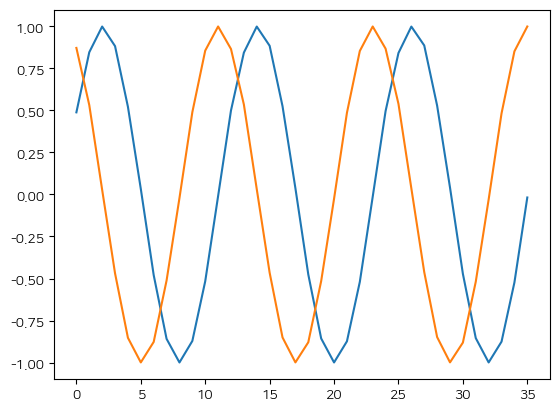

In [109]:
plt.plot(df_full["year_sin"].iloc[:36])
plt.plot(df_full["year_cos"].iloc[:36])

In [110]:
df_full.head()

,year,quarter,month,target_civil,target_ind,weight_civil,qva,relative_price,gas_price,oil_price,...,Non-OECD Europe and Eurasia,Non-OECD Middle East,Non-OECD Asia (Incl. China),Non-OECD Africa,Non-OECD Americas,qva_norm2015,year_sin,year_cos,season,year_linear
0,1996,Q1,1,605519.0,83809.0,0.87842,12183.433333,0.97,26.94,27.86,...,60.104264,11.95892,16.729374,7.252439,5.58697,30260.037031,0.488907,0.872336,0,0.083333
1,1996,Q1,2,566323.0,70427.0,0.88940,12183.433333,0.93,26.94,29.04,...,60.104264,11.95892,16.729374,7.252439,5.58697,30260.037031,0.846681,0.532100,0,0.166667
2,1996,Q1,3,477514.0,62652.0,0.88401,12183.433333,0.96,26.94,27.99,...,60.104264,11.95892,16.729374,7.252439,5.58697,30260.037031,0.999614,0.027790,1,0.25
3,1996,Q2,4,337794.0,47050.0,0.87774,12384.133333,0.94,26.94,28.74,...,60.104264,11.95892,16.729374,7.252439,5.58697,32502.439281,0.883136,-0.469116,1,0.333333
4,1996,Q2,5,184522.0,30709.0,0.85732,12384.133333,0.92,26.94,29.18,...,60.104264,11.95892,16.729374,7.252439,5.58697,32502.439281,0.522022,-0.852932,1,0.416667


## 2. EDA

In [111]:
df_eda = df_full.copy()
df_eda = df_eda.set_index(["year", "quarter", "month"])

### 산업용

In [112]:
dur_short = 12 * 2
dur_intm = 12 * 10
dur_long = 12 * 14

eda_df_dic = {
    "t0": pd.concat([df_eda, df_eda["target_civil"].shift(-1).to_frame(name="target_civil_t0"), df_eda["target_ind"].shift(-1).to_frame("target_ind_t0")], axis=1).dropna(),
    "short": pd.concat([df_eda, df_eda["target_civil"].shift(-dur_short).to_frame(name="target_civil_short"), df_eda["target_ind"].shift(-dur_short).to_frame("target_ind_short")], axis=1).dropna(),
    "intm": pd.concat([df_eda, df_eda["target_civil"].shift(-dur_intm).to_frame(name="target_civil_intm"), df_eda["target_ind"].shift(-dur_intm).to_frame("target_ind_intm")], axis=1).dropna(),
    "long": pd.concat([df_eda, df_eda["target_civil"].shift(-dur_long).to_frame(name="target_civil_long"), df_eda["target_ind"].shift(-dur_long).to_frame("target_ind_long")], axis=1).dropna(),
}

In [113]:
eda_df_dic["short"].head()

target_civil  target_ind  weight_civil           qva  \
year quarter month                                                         
1996 Q1      1          605519.0     83809.0       0.87842  12183.433333   
             2          566323.0     70427.0       0.88940  12183.433333   
             3          477514.0     62652.0       0.88401  12183.433333   
     Q2      4          337794.0     47050.0       0.87774  12384.133333   
             5          184522.0     30709.0       0.85732  12384.133333   

                    relative_price  gas_price  oil_price  전국평균_평균기온  \
year quarter month                                                    
1996 Q1      1                0.97      26.94      27.86   0.228111   
             2                0.93      26.94      29.04   0.452217   
             3                0.96      26.94      27.99   5.810599   
     Q2      4                0.94      26.94      28.74  10.981905   
             5                0.92      26.94      29.18  17.956682   

                    전국평균_최고기온  전국평균_최저기온  ...  Non-OECD Asia (Incl. China)  \
year quarter month                        ...                                
1996 Q1      1       5.244700  -3.864055  ...                    16.729374   
             2       5.899015  -4.014286  ...                    16.729374   
             3      10.777880   1.577419  ...                    16.729374   
     Q2      4      16.621905   5.960952  ...                    16.729374   
             5      23.966359  12.767742  ...                    16.729374   

                    Non-OECD Africa  Non-OECD Americas  qva_norm2015  \
year quarter month                                                     
1996 Q1      1             7.252439            5.58697  30260.037031   
             2             7.252439            5.58697  30260.037031   
             3             7.252439            5.58697  30260.037031   
     Q2      4             7.252439            5.58697  32502.439281   
             5             7.252439            5.58697  32502.439281   

                    year_sin  year_cos  season  year_linear  \
year quarter month                                            
1996 Q1      1      0.488907  0.872336       0     0.083333   
             2      0.846681  0.532100       0     0.166667   
             3      0.999614  0.027790       1         0.25   
     Q2      4      0.883136 -0.469116       1     0.333333   
             5      0.522022 -0.852932       1     0.416667   

                    target_civil_short  target_ind_short  
year quarter month                                        
1996 Q1      1                807493.0          143631.0  
             2                663455.0          118575.0  
             3                571545.0          124297.0  
     Q2      4                331872.0           88168.0  
             5                215061.0           86596.0  

[5 rows x 77 columns]

In [114]:
eda_df_dic["intm"].head()

target_civil  target_ind  weight_civil           qva  \
year quarter month                                                         
1996 Q1      1          605519.0     83809.0       0.87842  12183.433333   
             2          566323.0     70427.0       0.88940  12183.433333   
             3          477514.0     62652.0       0.88401  12183.433333   
     Q2      4          337794.0     47050.0       0.87774  12384.133333   
             5          184522.0     30709.0       0.85732  12384.133333   

                    relative_price  gas_price  oil_price  전국평균_평균기온  \
year quarter month                                                    
1996 Q1      1                0.97      26.94      27.86   0.228111   
             2                0.93      26.94      29.04   0.452217   
             3                0.96      26.94      27.99   5.810599   
     Q2      4                0.94      26.94      28.74  10.981905   
             5                0.92      26.94      29.18  17.956682   

                    전국평균_최고기온  전국평균_최저기온  ...  Non-OECD Asia (Incl. China)  \
year quarter month                        ...                                
1996 Q1      1       5.244700  -3.864055  ...                    16.729374   
             2       5.899015  -4.014286  ...                    16.729374   
             3      10.777880   1.577419  ...                    16.729374   
     Q2      4      16.621905   5.960952  ...                    16.729374   
             5      23.966359  12.767742  ...                    16.729374   

                    Non-OECD Africa  Non-OECD Americas  qva_norm2015  \
year quarter month                                                     
1996 Q1      1             7.252439            5.58697  30260.037031   
             2             7.252439            5.58697  30260.037031   
             3             7.252439            5.58697  30260.037031   
     Q2      4             7.252439            5.58697  32502.439281   
             5             7.252439            5.58697  32502.439281   

                    year_sin  year_cos  season  year_linear  \
year quarter month                                            
1996 Q1      1      0.488907  0.872336       0     0.083333   
             2      0.846681  0.532100       0     0.166667   
             3      0.999614  0.027790       1         0.25   
     Q2      4      0.883136 -0.469116       1     0.333333   
             5      0.522022 -0.852932       1     0.416667   

                    target_civil_intm  target_ind_intm  
year quarter month                                      
1996 Q1      1              1663668.0         403770.0  
             2              1465276.0         369548.0  
             3              1252496.0         380259.0  
     Q2      4               827127.0         307253.0  
             5               470598.0         276380.0  

[5 rows x 77 columns]

In [115]:
eda_df_dic["long"].head()

target_civil  target_ind  weight_civil           qva  \
year quarter month                                                         
1996 Q1      1          605519.0     83809.0       0.87842  12183.433333   
             2          566323.0     70427.0       0.88940  12183.433333   
             3          477514.0     62652.0       0.88401  12183.433333   
     Q2      4          337794.0     47050.0       0.87774  12384.133333   
             5          184522.0     30709.0       0.85732  12384.133333   

                    relative_price  gas_price  oil_price  전국평균_평균기온  \
year quarter month                                                    
1996 Q1      1                0.97      26.94      27.86   0.228111   
             2                0.93      26.94      29.04   0.452217   
             3                0.96      26.94      27.99   5.810599   
     Q2      4                0.94      26.94      28.74  10.981905   
             5                0.92      26.94      29.18  17.956682   

                    전국평균_최고기온  전국평균_최저기온  ...  Non-OECD Asia (Incl. China)  \
year quarter month                        ...                                
1996 Q1      1       5.244700  -3.864055  ...                    16.729374   
             2       5.899015  -4.014286  ...                    16.729374   
             3      10.777880   1.577419  ...                    16.729374   
     Q2      4      16.621905   5.960952  ...                    16.729374   
             5      23.966359  12.767742  ...                    16.729374   

                    Non-OECD Africa  Non-OECD Americas  qva_norm2015  \
year quarter month                                                     
1996 Q1      1             7.252439            5.58697  30260.037031   
             2             7.252439            5.58697  30260.037031   
             3             7.252439            5.58697  30260.037031   
     Q2      4             7.252439            5.58697  32502.439281   
             5             7.252439            5.58697  32502.439281   

                    year_sin  year_cos  season  year_linear  \
year quarter month                                            
1996 Q1      1      0.488907  0.872336       0     0.083333   
             2      0.846681  0.532100       0     0.166667   
             3      0.999614  0.027790       1         0.25   
     Q2      4      0.883136 -0.469116       1     0.333333   
             5      0.522022 -0.852932       1     0.416667   

                    target_civil_long  target_ind_long  
year quarter month                                      
1996 Q1      1              2007813.0         666375.0  
             2              1485036.0         521594.0  
             3              1351544.0         604348.0  
     Q2      4               961861.0         510337.0  
             5               542735.0         446416.0  

[5 rows x 77 columns]

**correlation table**

In [116]:
df_corr = pd.concat([
    eda_df_dic["t0"].corr().iloc[:-2, -2:],
    eda_df_dic["short"].corr().iloc[:-2, -2:],
    eda_df_dic["intm"].corr().iloc[:-2, -2:],
    eda_df_dic["long"].corr().iloc[:-2, -2:],
], axis=1)
df_corr = {
    "target_civil": df_corr.filter(regex="target_civil"),
    "target_ind":  df_corr.filter(regex="target_ind"),
}

In [117]:
# dur_vars = ["target_civil_t0", "target_civil_short", "target_civil_intm", "target_civil_long"]
# df_corr["target_civil"]["target_civil_mean"] = df_corr["target_civil"][dur_vars].mean(axis=1)
# df_corr["target_civil"]["target_civil_std"] = df_corr["target_civil"][dur_vars].std(axis=1)
# df_corr["target_civil"]["target_civil_meantostd"] = df_corr["target_civil"]["target_civil_mean"] / (df_corr["target_civil"]["target_civil_std"] + 1)
# df_corr["target_civil"]["target_civil_longtoshort"] = df_corr["target_civil"]["target_civil_long"].abs() / (df_corr["target_civil"]["target_civil_short"].abs() + 1)
# df_summary = df_corr["target_civil"].round(4).iloc[np.argsort(df_corr["target_civil"]["target_civil_short"].abs().values)[::-1]]
# # df_summary.loc[df_summary["target_civil_meantostd"].abs() > 0.2]
# df_summary.iloc[:20]

In [118]:
# dur_vars = ["target_ind_t0", "target_ind_short", "target_ind_intm", "target_ind_long"]
dur_vars = ["target_ind_t0", "target_ind_short", "target_ind_intm", "target_ind_long"]
df_corr["target_ind"]["target_ind_mean"] = df_corr["target_ind"][dur_vars].abs().mean(axis=1)
df_corr["target_ind"]["target_ind_std"] = df_corr["target_ind"][dur_vars].std(axis=1)
df_corr["target_ind"]["target_ind_meantostd"] = df_corr["target_ind"]["target_ind_mean"] / (df_corr["target_ind"]["target_ind_std"] + 1)
df_corr["target_ind"]["target_ind_longtoshort"] = df_corr["target_ind"]["target_ind_long"].abs() / (df_corr["target_ind"]["target_ind_short"].abs() + 1)

df_summary = df_corr["target_ind"].round(4).iloc[np.argsort(df_corr["target_ind"]["target_ind_meantostd"].abs().values)[::-1]]
display(df_summary[dur_vars + ["target_ind_mean", "target_ind_std", "target_ind_meantostd", "target_ind_longtoshort"]].iloc[:50])
# base feature : mean to std 0.35 이상만

,target_ind_t0,target_ind_short,target_ind_intm,target_ind_long,target_ind_mean,target_ind_std,target_ind_meantostd,target_ind_longtoshort
target_ind,0.9621,0.9275,0.7047,0.3021,0.7241,0.3036,0.5555,0.1567
target_civil,0.4412,0.5968,0.7170,0.6401,0.5988,0.1162,0.5364,0.4009
국내 해수면 높이,0.7599,0.7135,0.6311,0.1830,0.5719,0.2647,0.4522,0.1068
korea_pop,0.8848,0.8439,0.5810,-0.0392,0.5872,0.4264,0.4117,0.0213
Non-OECD Americas,0.8908,0.8566,0.5512,-0.0535,0.5880,0.4374,0.4091,0.0288
qva,0.8975,0.8528,0.4946,-0.0830,0.5820,0.4531,0.4005,0.0448
gdp_nominal,0.8742,0.8235,0.4927,-0.0632,0.5634,0.4312,0.3937,0.0346
Non-OECD Asia (Incl. China),0.8957,0.8757,0.4533,-0.0409,0.5664,0.4412,0.3930,0.0218
year_cos,0.2831,0.3281,0.5393,0.7497,0.4751,0.2145,0.3912,0.5645
SF_TMP_고도평균,0.4829,0.4897,0.4045,0.3138,0.4227,0.0823,0.3906,0.2106


In [119]:
df_summary = df_corr["target_ind"].round(4).iloc[np.argsort(df_corr["target_ind"]["target_ind_t0"].abs().values)[::-1]]
display(df_summary[dur_vars + ["target_ind_mean", "target_ind_std", "target_ind_meantostd", "target_ind_longtoshort"]].iloc[:30])
t0_term_vars = ["target_ind", "수출", "qva", "Non-OECD Asia (Incl. China)", "korea_pop"]

,target_ind_t0,target_ind_short,target_ind_intm,target_ind_long,target_ind_mean,target_ind_std,target_ind_meantostd,target_ind_longtoshort
target_ind,0.9621,0.9275,0.7047,0.3021,0.7241,0.3036,0.5555,0.1567
수출,0.9044,0.8368,0.3360,-0.0220,0.5248,0.4381,0.3650,0.0120
qva,0.8975,0.8528,0.4946,-0.0830,0.5820,0.4531,0.4005,0.0448
Non-OECD Asia (Incl. China),0.8957,0.8757,0.4533,-0.0409,0.5664,0.4412,0.3930,0.0218
Non-OECD Americas,0.8908,0.8566,0.5512,-0.0535,0.5880,0.4374,0.4091,0.0288
Non-OECD Middle East,0.8864,0.8442,0.4368,-0.0677,0.5588,0.4441,0.3870,0.0367
korea_pop,0.8848,0.8439,0.5810,-0.0392,0.5872,0.4264,0.4117,0.0213
gdp_nominal,0.8742,0.8235,0.4927,-0.0632,0.5634,0.4312,0.3937,0.0346
gas_price,0.8369,0.8148,0.4868,-0.0244,0.5407,0.4019,0.3857,0.0134
글로벌_수심수온편차_0to2000,0.8318,0.7844,0.4479,-0.0721,0.5340,0.4167,0.3770,0.0404


In [120]:
df_summary = df_corr["target_ind"].round(4).iloc[np.argsort(df_corr["target_ind"]["target_ind_short"].abs().values)[::-1]]
display(df_summary[dur_vars + ["target_ind_mean", "target_ind_std", "target_ind_meantostd", "target_ind_longtoshort"]].iloc[:30])
short_term_vars = ["target_ind", "Non-OECD Asia (Incl. China)", "qva", "korea_pop", "수출"]

,target_ind_t0,target_ind_short,target_ind_intm,target_ind_long,target_ind_mean,target_ind_std,target_ind_meantostd,target_ind_longtoshort
target_ind,0.9621,0.9275,0.7047,0.3021,0.7241,0.3036,0.5555,0.1567
Non-OECD Asia (Incl. China),0.8957,0.8757,0.4533,-0.0409,0.5664,0.4412,0.3930,0.0218
Non-OECD Americas,0.8908,0.8566,0.5512,-0.0535,0.5880,0.4374,0.4091,0.0288
qva,0.8975,0.8528,0.4946,-0.0830,0.5820,0.4531,0.4005,0.0448
Non-OECD Middle East,0.8864,0.8442,0.4368,-0.0677,0.5588,0.4441,0.3870,0.0367
korea_pop,0.8848,0.8439,0.5810,-0.0392,0.5872,0.4264,0.4117,0.0213
수출,0.9044,0.8368,0.3360,-0.0220,0.5248,0.4381,0.3650,0.0120
Non-OECD Africa,0.8245,0.8281,0.4798,-0.0445,0.5442,0.4115,0.3856,0.0244
gdp_nominal,0.8742,0.8235,0.4927,-0.0632,0.5634,0.4312,0.3937,0.0346
gas_price,0.8369,0.8148,0.4868,-0.0244,0.5407,0.4019,0.3857,0.0134


In [121]:
df_summary = df_corr["target_ind"].round(4).iloc[np.argsort(df_corr["target_ind"]["target_ind_intm"].abs().values)[::-1]]
display(df_summary[dur_vars + ["target_ind_mean", "target_ind_std", "target_ind_meantostd", "target_ind_longtoshort"]].iloc[:30])
intm_term_vars = ["target_civil", "target_ind", "korea_pop", "OECD", "SF_TMP_5m"]

,target_ind_t0,target_ind_short,target_ind_intm,target_ind_long,target_ind_mean,target_ind_std,target_ind_meantostd,target_ind_longtoshort
target_civil,0.4412,0.5968,0.7170,0.6401,0.5988,0.1162,0.5364,0.4009
target_ind,0.9621,0.9275,0.7047,0.3021,0.7241,0.3036,0.5555,0.1567
국내 해수면 높이,0.7599,0.7135,0.6311,0.1830,0.5719,0.2647,0.4522,0.1068
korea_pop,0.8848,0.8439,0.5810,-0.0392,0.5872,0.4264,0.4117,0.0213
OECD,0.7028,0.6751,0.5704,-0.0858,0.5085,0.3720,0.3707,0.0512
SF_TMP_5m,0.5091,0.5401,0.5650,0.1203,0.4336,0.2102,0.3583,0.0781
Non-OECD Americas,0.8908,0.8566,0.5512,-0.0535,0.5880,0.4374,0.4091,0.0288
year_cos,0.2831,0.3281,0.5393,0.7497,0.4751,0.2145,0.3912,0.5645
서울_최고기온,-0.1709,-0.3166,-0.5281,-0.7165,0.4330,0.2392,0.3494,0.5442
부산_최저습도,-0.2255,-0.3343,-0.5209,-0.6173,0.4245,0.1772,0.3606,0.4626


In [122]:
df_summary = df_corr["target_ind"].round(4).iloc[np.argsort(df_corr["target_ind"]["target_ind_long"].abs().values)[::-1]]
# df_summary.loc[df_summary["target_ind_meantostd"].abs() > 0.2]
# df_summary.iloc[:20]
display(df_summary[dur_vars + ["target_ind_mean", "target_ind_std", "target_ind_meantostd", "target_ind_longtoshort"]].iloc[:30])
long_term_vars = ["year_cos", "서울_최고기온", "eurasia_snow_cover", "부산_평균습도", "target_civil"]

,target_ind_t0,target_ind_short,target_ind_intm,target_ind_long,target_ind_mean,target_ind_std,target_ind_meantostd,target_ind_longtoshort
year_cos,0.2831,0.3281,0.5393,0.7497,0.4751,0.2145,0.3912,0.5645
서울_최고기온,-0.1709,-0.3166,-0.5281,-0.7165,0.4330,0.2392,0.3494,0.5442
전국평균_최고기온,-0.1722,-0.3158,-0.5153,-0.7122,0.4289,0.2355,0.3471,0.5413
서울_평균기온,-0.1770,-0.3175,-0.5109,-0.7121,0.4294,0.2329,0.3483,0.5405
서울_최저기온,-0.1759,-0.3109,-0.4941,-0.7094,0.4226,0.2314,0.3432,0.5411
전국평균_평균기온,-0.1626,-0.3028,-0.4997,-0.7062,0.4178,0.2368,0.3378,0.5421
전국평균_최저기온,-0.1547,-0.2916,-0.4835,-0.6977,0.4069,0.2362,0.3291,0.5402
eurasia_snow_cover,0.1578,0.2983,0.4892,0.6977,0.4107,0.2346,0.3327,0.5374
부산_최고기온,-0.1437,-0.3001,-0.5039,-0.6793,0.4067,0.2340,0.3296,0.5225
부산_평균기온,-0.1387,-0.2881,-0.4932,-0.6752,0.3988,0.2347,0.3230,0.5242


### 민간용

### EDA for short term, long term threshold

In [123]:
# dur_short = 12 * 2
# dur_intm = 12 * 8
# dur_long = 12 * 14

# eda_df_dic = {
#     "t0": pd.concat([df_eda, df_eda["target_civil"].shift(-1).to_frame(name="target_civil_t0"), df_eda["target_ind"].shift(-1).to_frame("target_ind_t0")], axis=1).dropna(),
#     "short": pd.concat([df_eda, df_eda["target_civil"].shift(-dur_short).to_frame(name="target_civil_short"), df_eda["target_ind"].shift(-dur_short).to_frame("target_ind_short")], axis=1).dropna(),
#     "intm": pd.concat([df_eda, df_eda["target_civil"].shift(-dur_intm).to_frame(name="target_civil_intm"), df_eda["target_ind"].shift(-dur_intm).to_frame("target_ind_intm")], axis=1).dropna(),
#     "long": pd.concat([df_eda, df_eda["target_civil"].shift(-dur_long).to_frame(name="target_civil_long"), df_eda["target_ind"].shift(-dur_long).to_frame("target_ind_long")], axis=1).dropna(),
# }

In [124]:
for i in range(1, 169, 1):
    eda_df_dic["t" + str(i)] = pd.concat([
        df_eda,
        df_eda["target_ind"].shift(-i).to_frame(name="target_civil_t" + str(i)),
        df_eda["target_ind"].shift(-i).to_frame("target_ind_t" + str(i))
    ], axis=1).dropna()

In [125]:
tmp_shorterm = []
tmp_longterm = []

for i in range(1, 169, 1):
    df_corr = eda_df_dic["t" + str(i)].copy()
    tmp_shorterm.append(df_corr.corr().iloc[:-2, -2:].loc[short_term_vars, "target_ind_t" + str(i)].abs().mean())
    tmp_longterm.append(df_corr.corr().iloc[:-2, -2:].loc[long_term_vars, "target_ind_t" + str(i)].abs().mean())
#     df_corr["target_civil"]["target_civil_mean"] = df_corr["target_civil"][dur_vars].mean(axis=1)
#     df_corr["target_civil"]["target_civil_std"] = df_corr["target_civil"][dur_vars].std(axis=1)
#     df_corr["target_civil"]["target_civil_meantostd"] = df_corr["target_civil"]["target_civil_mean"] / (df_corr["target_civil"]["target_civil_std"] + 1)
#     df_corr["target_civil"]["target_civil_longtoshort"] = df_corr["target_civil"]["target_civil_long"].abs() / (df_corr["target_civil"]["target_civil_short"].abs() + 1)
#     break
    

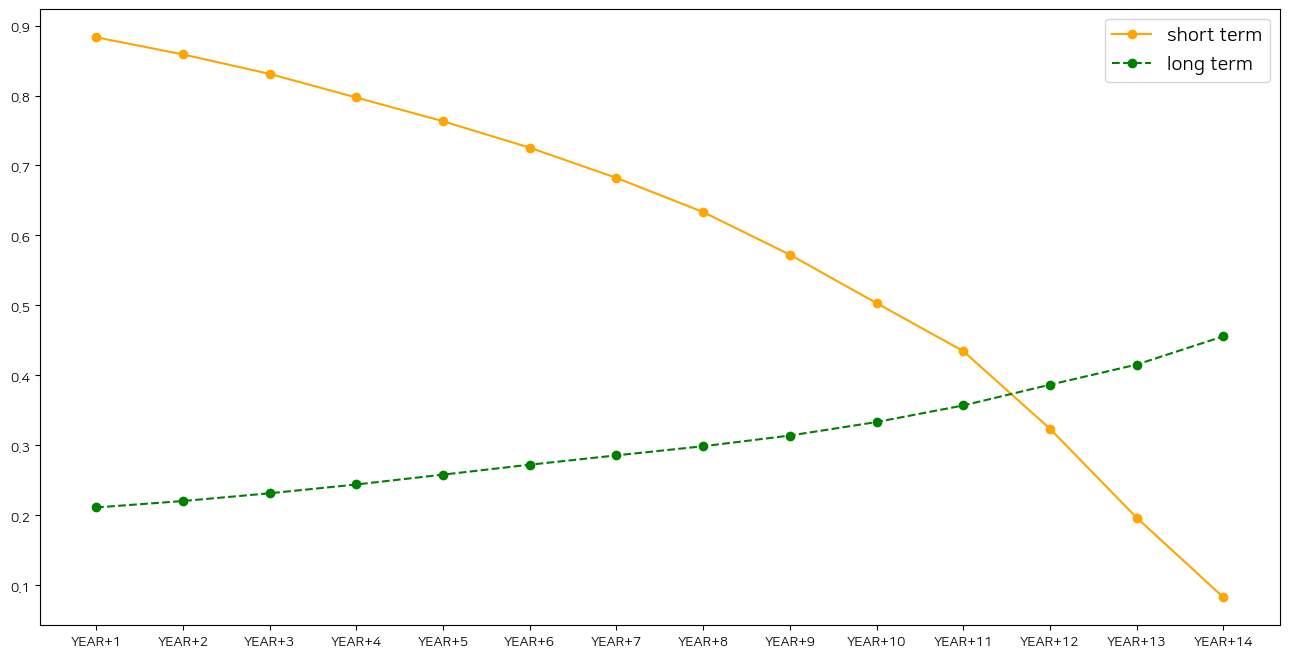

In [126]:
plt.figure(figsize=(16, 8))

plt.plot(
    ["YEAR+" + str(i+1) for i in range(14)],
    [np.mean(tmp_shorterm[((i+1)*12-12):((i+1)*12)]) for i in range(14)],
    color="orange", marker="o", label="short term"
)
plt.plot(
    ["YEAR+" + str(i+1) for i in range(14)],
    [np.mean(tmp_longterm[((i+1)*12-12):((i+1)*12)]) for i in range(14)],
    linestyle="--", color="green", marker="o", label="long term"
)

plt.legend(fontsize=14)
plt.show()

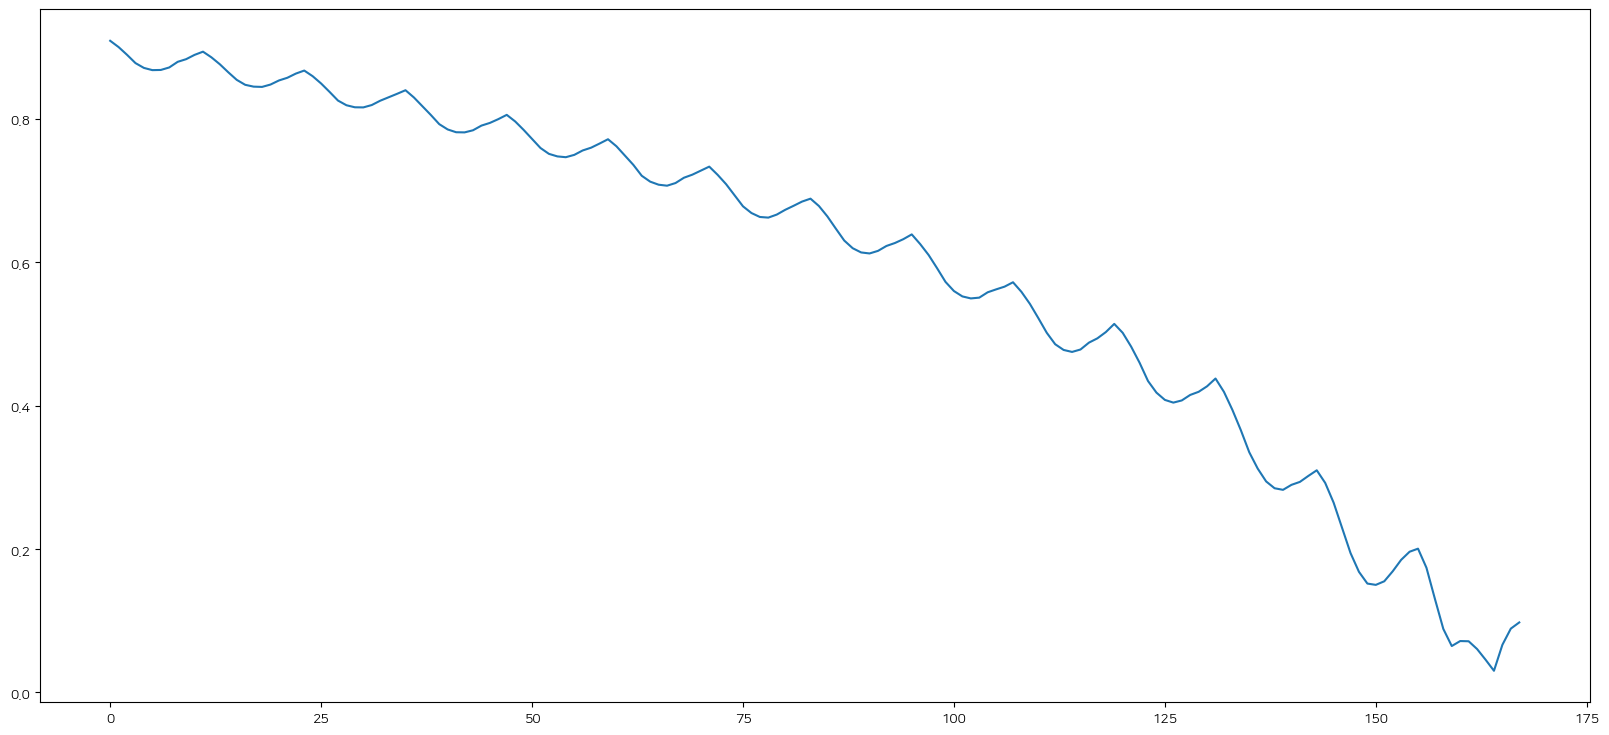

In [127]:
plt.figure(figsize=(20, 9))
plt.plot(tmp_shorterm)
plt.show()

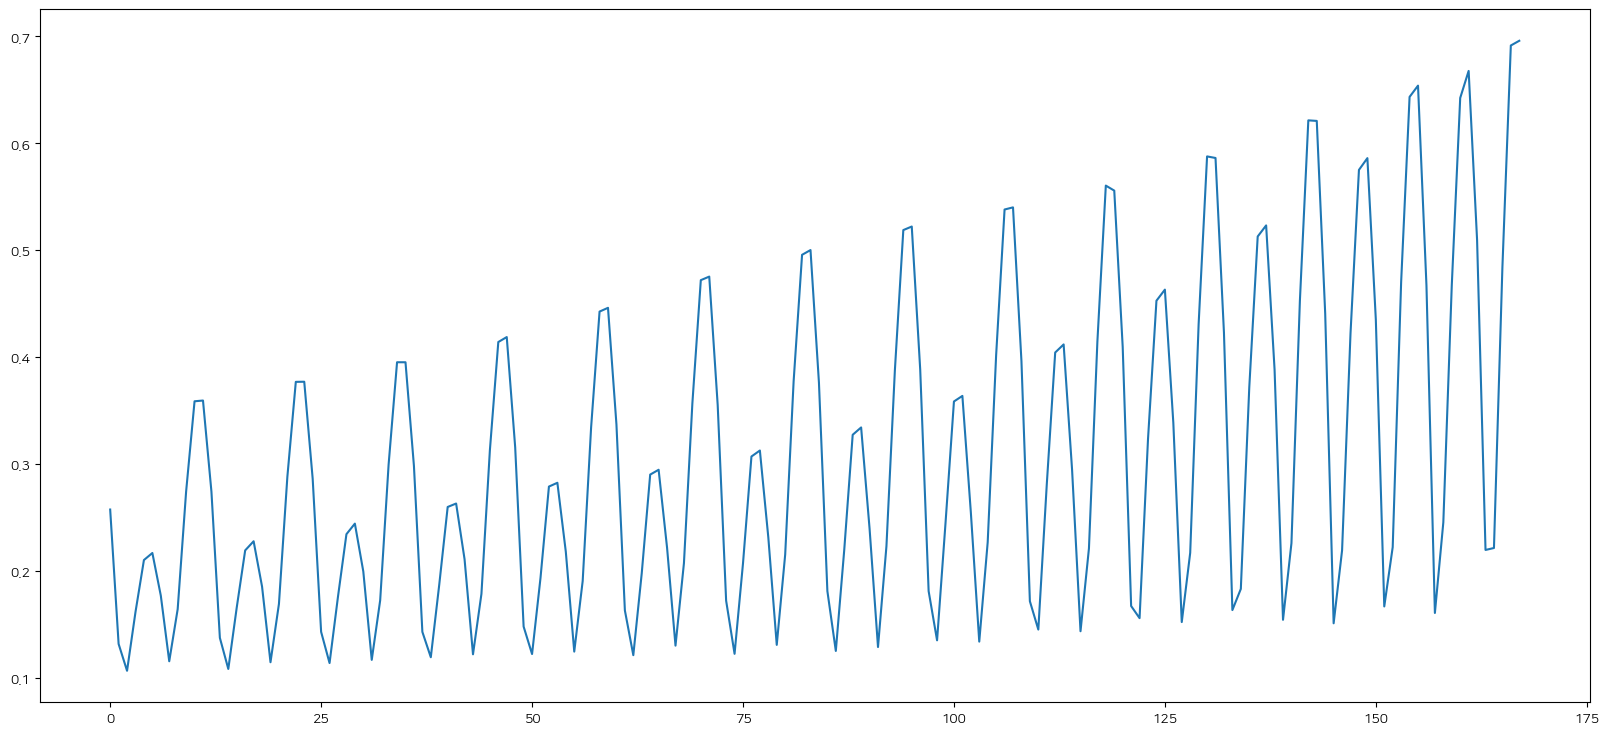

In [128]:
plt.figure(figsize=(20, 9))
plt.plot(tmp_longterm)
plt.show()

**2-1. Distributin on Target (민간용)**

* 민간용 수요는 2005년까지 점진적으로 증가세를 보인다. 그 이후에는 횡보하는 모습이다.

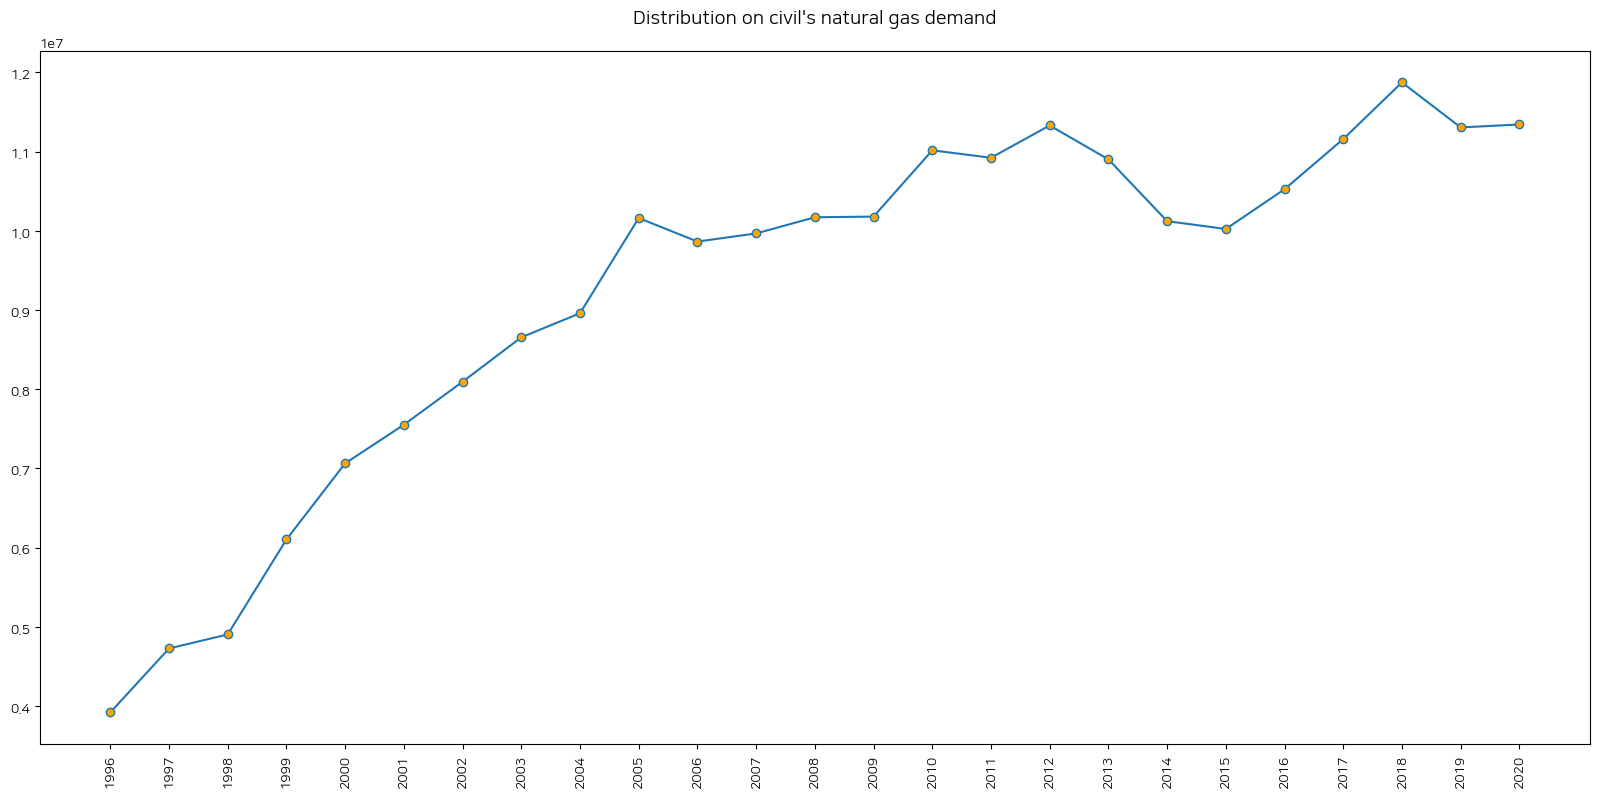

In [134]:
plt.figure(figsize=(20, 9))
plt.plot([str(i) for i in df_eda.groupby(["year"]).sum().index.values], df_eda.groupby(["year"]).sum()["target_civil"].values, marker="o", mfc="orange")
plt.title("Distribution on civil's natural gas demand", pad=20, fontsize=14, fontweight="bold")
plt.xticks(rotation=90)
plt.show()

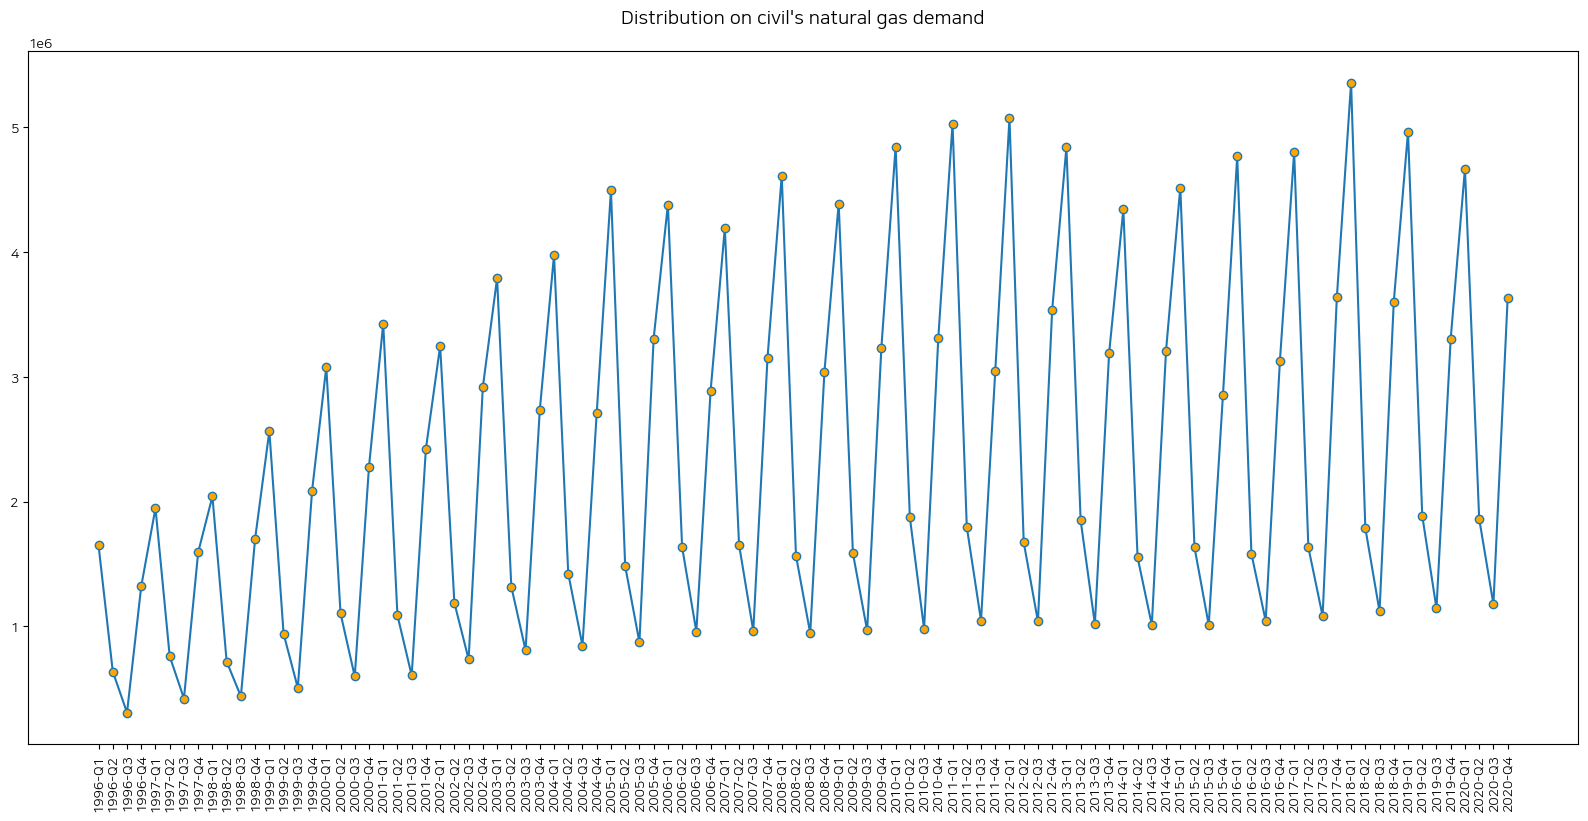

In [132]:
plt.figure(figsize=(20, 9))
plt.plot([str(i[0]) + "-" + str(i[1]) for i in df_eda.groupby(["year", "quarter"]).sum().index.values], df_eda.groupby(["year", "quarter"]).sum()["target_civil"].values, marker="o", mfc="orange")
plt.title("Distribution on civil's natural gas demand", pad=20, fontsize=14, fontweight="bold")
plt.xticks(rotation=90)
plt.show()

**2-2. Distributin on Target (산업용)**

* 산업용 수요는 2012년까지 급격한 상승세를 보이다가 이후 살짝 감소 및 횡보하는 모습이다.

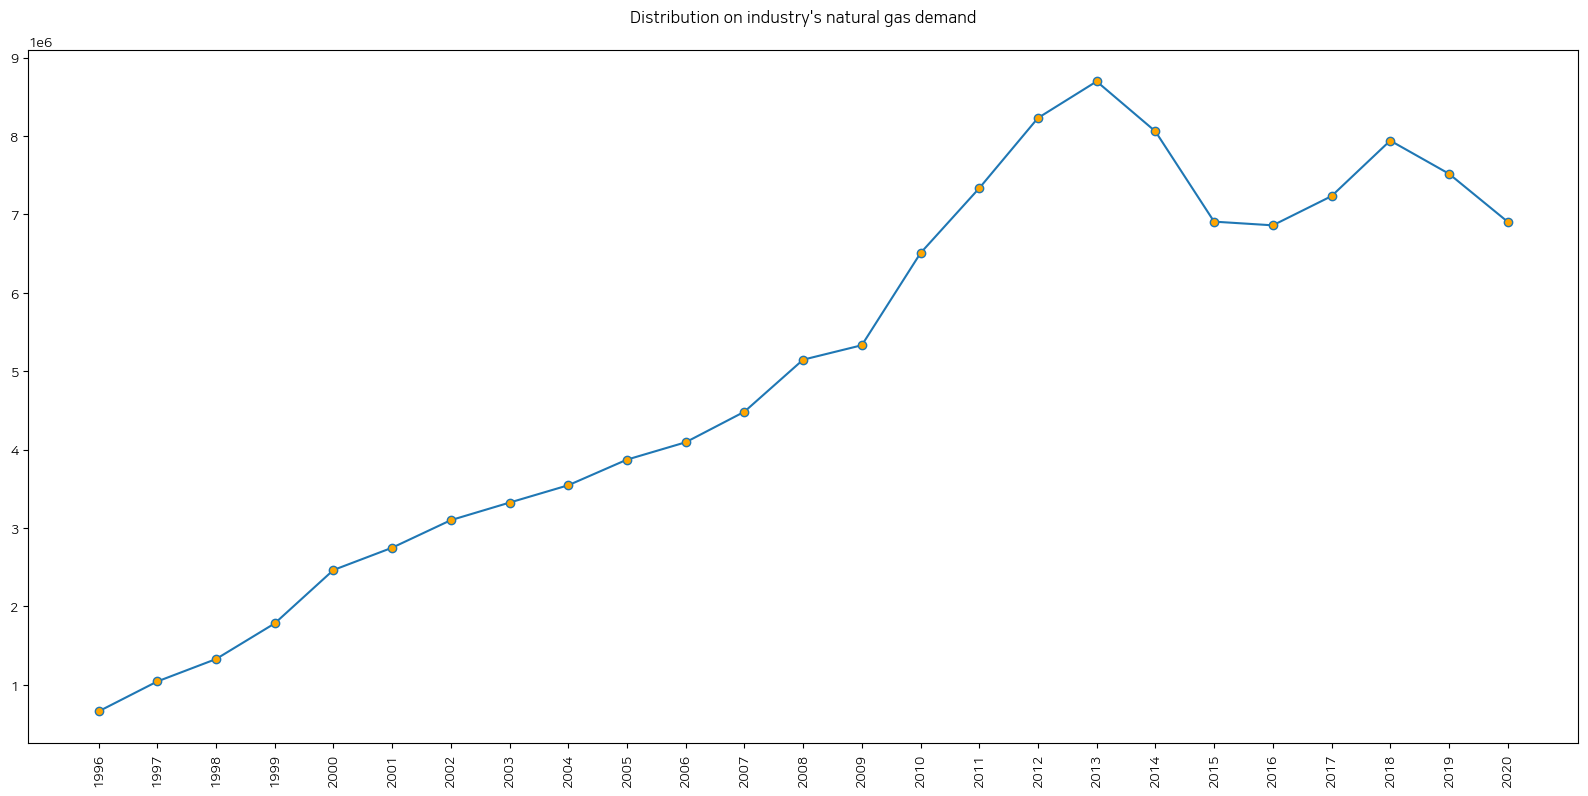

In [135]:
plt.figure(figsize=(20, 9))
plt.plot([str(i) for i in df_eda.groupby(["year"]).sum().index.values], df_eda.groupby(["year"]).sum()["target_ind"].values, marker="o", mfc="orange")
plt.title("Distribution on industry's natural gas demand", pad=20)
plt.xticks(rotation=90)
plt.show()

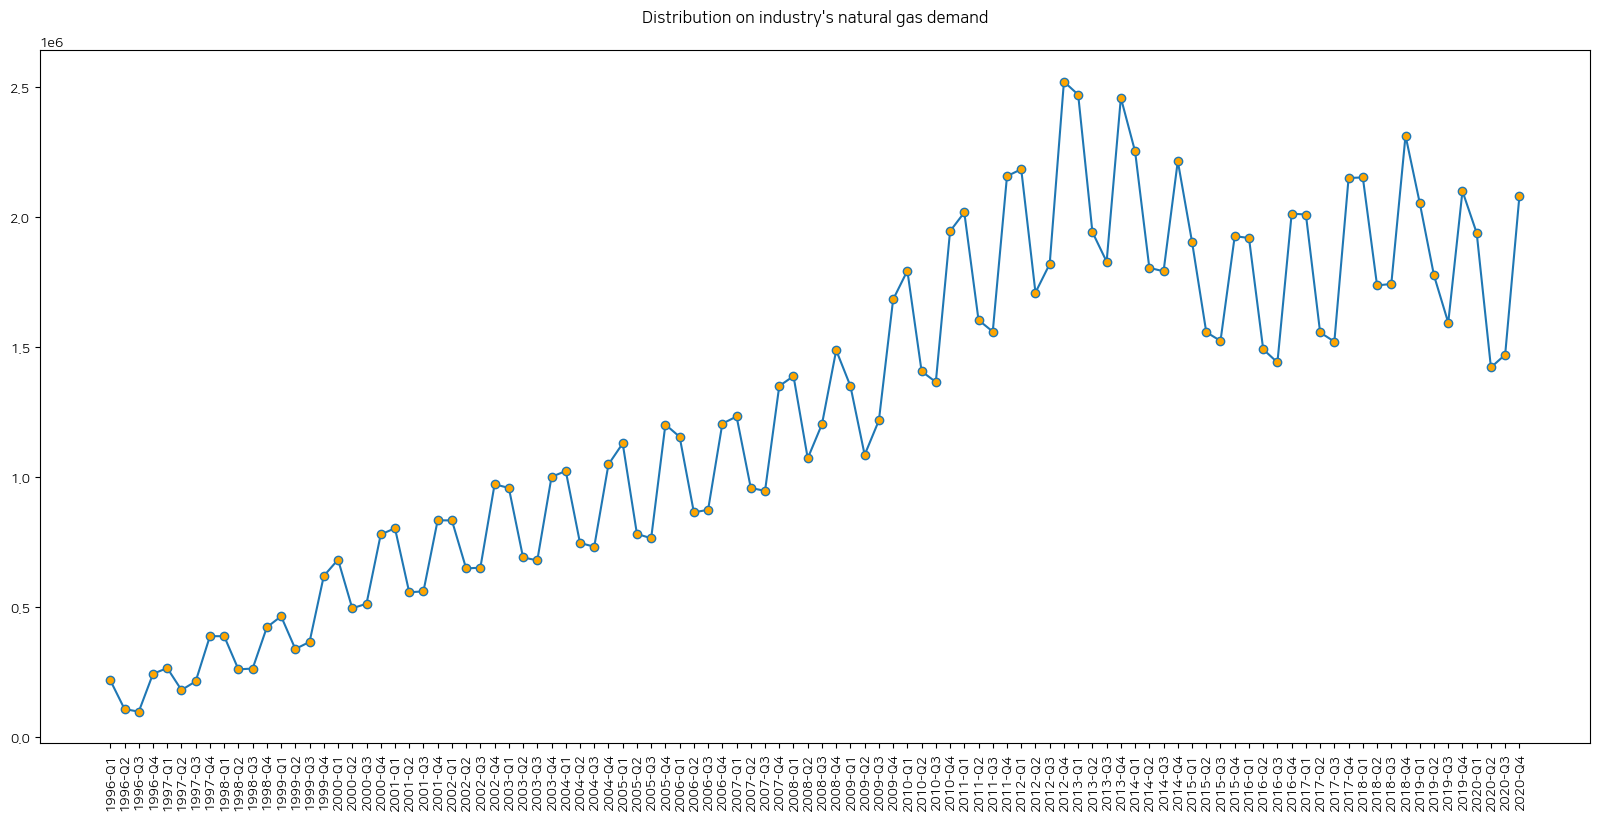

In [130]:
plt.figure(figsize=(20, 9))
plt.plot([str(i[0]) + "-" + str(i[1]) for i in df_eda.groupby(["year", "quarter"]).sum().index.values], df_eda.groupby(["year", "quarter"]).sum()["target_ind"].values, marker="o", mfc="orange")
plt.title("Distribution on industry's natural gas demand", pad=20)
plt.xticks(rotation=90)
plt.show()

**2-3. Distribution on features by timeseries**

* 산업용대비 민간용 수요는 점차 줄고 있다. (민간용은 그래도이나 산업용 수요가 2012년까지 점차 증가했기 때문)
* 산업용 부가가치는 지속적으로 증가 중 (명목가치로 계산된 것으로 보여 실질적으로 증가했는지는 추가 작업을 통해 확인해야함)
* 천연가스 가격은 2013년 까지 상승 후 하락
* 오일 가격은 2011년 까지 상승 후 하락

In [ ]:
for i in df_eda.columns:
    if i in target_vars:
        continue
    plt.figure(figsize=(20, 9))
    plt.plot([str(i[0]) + "-" + str(i[1]) for i in df_eda.groupby(["year", "quarter"]).mean().index.values], df_eda.groupby(["year", "quarter"]).mean()[i].values, marker="o", mfc="orange")
    plt.title("Distribution on " + i, pad=20)
    plt.xticks(rotation=90)
    plt.show()

**2-4. Scatter plot on feature & target (민간용) - short**
* 상대가격은 민간용 수요와 크게 상관성이 없음
* 산업용 수요와 비교했을 시, 민간용 수요는 가격과 큰 상관성이 없다고 보여짐
* **기후관련 feature는 큰 상관성이 있을 것이라고 기대됨**
* 바로 다음 월과의 상관관계보다 같은 월에 대해 더 큰 상관관계를 가짐 (계절 영향일 것으로 보임)

In [ ]:
for i in eda_df_dic["short"].columns:
    if i in ["target_civil_short", "target_ind_short"]:
        continue
    plt.figure(figsize=(12, 8))
    plt.scatter(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_civil_short"].values, color="orange", edgecolor="black")
    corr = np.corrcoef(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_civil_short"].values)[0,1]
    plt.title(f"Scatter plot on {i} (민간용 short term) - (Correlation={np.round(corr, 3)})", pad=20, weight="bold", fontsize=14)
    x_range = plt.xlim()
    y_range = plt.ylim()
    reg = linregress(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_civil_short"].values)
    corr = np.corrcoef(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_civil_short"].values)[0,1]
    plt.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="green")
    plt.xlim(x_range)
#     plt.text(x_range[0] + 0.1 * np.abs(x_range[0]), y_range[1] - 0.1 * np.abs(y_range[1]), s=f"Correlation : {np.round(corr, 3)}", weight="bold", fontsize=12)
    plt.show()

**2-4. Scatter plot on feature & target (민간용) - long**

In [ ]:
for i in eda_df_dic["long"].columns:
    if i in ["target_civil_long", "target_ind_long"]:
        continue
    plt.figure(figsize=(12, 8))
    plt.scatter(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_civil_long"].values, color="orange", edgecolor="black")
    corr = np.corrcoef(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_civil_long"].values)[0,1]
    plt.title(f"Scatter plot on {i} (민간용 long term) - (Correlation : {np.round(corr, 3)})", pad=20, weight="bold", fontsize=14)
    x_range = plt.xlim()
    y_range = plt.ylim()
    reg = linregress(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_civil_long"].values)
    corr = np.corrcoef(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_civil_long"].values)[0,1]
    plt.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="green")
    plt.xlim(x_range)
#     plt.text(x_range[0] + 0.1 * np.abs(x_range[0]), y_range[1] - 0.1 * np.abs(y_range[1]), s=f"Correlation : {np.round(corr, 3)}", weight="bold", fontsize=12)
    plt.show()

**2-5. Scatter plot on feature & target (산업용) - short**

* 산업용부가가치와 큰 양의 상관관계를 가짐 
* 천연가스 가격 뿐만 아닌 오일 가격과도 큰 양의 상관관계를 가짐
* **산업용 부분은 기후보다 경제상황과 관련된 feature와 큰 상관성을 가질 것이라고 기대 됨**

In [ ]:
for i in eda_df_dic["short"].columns:
    if i in ["target_civil_short", "target_ind_short"]:
        continue
    plt.figure(figsize=(12, 8))
    plt.scatter(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_ind_short"].values, color="orange", edgecolor="black")
    corr = np.corrcoef(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_ind_short"].values)[0,1]
    plt.title(f"Scatter plot on {i} (산업용 short term) - (Correlation : {np.round(corr, 3)})", pad=20, weight="bold", fontsize=14)
    x_range = plt.xlim()
    y_range = plt.ylim()
    reg = linregress(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_ind_short"].values)
    corr = np.corrcoef(eda_df_dic["short"][i].values, eda_df_dic["short"]["target_ind_short"].values)[0,1]
    plt.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="green")
    plt.xlim(x_range)
#     plt.text(x_range[0] + 0.1 * np.abs(x_range[0]), y_range[1] - 0.1 * np.abs(y_range[1]), s=f"Correlation : {np.round(corr, 3)}", weight="bold", fontsize=12)
    plt.show()

**2-5. Scatter plot on feature & target (산업용) - long**

In [ ]:
for i in eda_df_dic["long"].columns:
    if i in ["target_civil_long", "target_ind_long"]:
        continue
    plt.figure(figsize=(12, 8))
    plt.scatter(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_ind_long"].values, color="orange", edgecolor="black")
    corr = np.corrcoef(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_ind_long"].values)[0,1]
    plt.title(f"Scatter plot on {i} (산업용 short term) - (Correlation : {np.round(corr, 3)})", pad=20, weight="bold", fontsize=14)
    x_range = plt.xlim()
    y_range = plt.ylim()
    reg = linregress(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_ind_long"].values)
    corr = np.corrcoef(eda_df_dic["long"][i].values, eda_df_dic["long"]["target_ind_long"].values)[0,1]
    plt.axline(xy1=(0, reg.intercept), slope=reg.slope, linestyle="--", color="green")
    plt.xlim(x_range)
#     plt.text(x_range[0] + 0.1 * np.abs(x_range[0]), y_range[1] - 0.1 * np.abs(y_range[1]), s=f"Correlation : {np.round(corr, 3)}", weight="bold", fontsize=12)
    plt.show()

**create data pipeline**

In [ ]:
df_full.isna().sum().sum()

In [ ]:
nontrain_vars = ["year"]
bin_vars = []
cat_vars = ["quarter", "month"]
num_vars = diff(df_full.columns, target_vars + nontrain_vars + bin_vars + cat_vars)

In [ ]:
df_full[num_vars] = df_full[num_vars].astype("float32")

In [ ]:
pred_steps = 168
seqLength = 12 + 1

def get_multilabel(df):
    concat_list = []
    for i in range(len(df)):
        valid_split_point = len(df) - pred_steps - i
        if valid_split_point < 1:
            valid_split_point += 1
            i -= 1
            break
        tmp_target = df[target_vars].iloc[valid_split_point:(len(df)-i)]
        tmp_civil = tmp_target["target_civil"].to_frame().T
        tmp_civil.columns = ["target_civil_t" + str(i) for i in range(pred_steps)]

        tmp_ind = tmp_target["target_ind"].to_frame().T
        tmp_ind.columns = ["target_ind_t" + str(i) for i in range(pred_steps)]

        concat_list.append(
            pd.concat([
                df.iloc[valid_split_point-1].to_frame().T.reset_index(drop=True),
                tmp_civil.reset_index(drop=True), tmp_ind.reset_index(drop=True)
            ], axis=1)
        )
    return pd.concat(concat_list, axis=0, ignore_index=True)[::-1].reset_index(drop=True)

In [ ]:
ref_date_range = pd.Index(df_full[["year", "quarter", "month"]].iloc[(seqLength-1):])
df_full = df_full.drop(nontrain_vars, axis=1)

ohe = OneHotEncoder(sparse=False)
df_full = pd.concat([df_full.drop(cat_vars, axis=1), pd.DataFrame(ohe.fit_transform(df_full[cat_vars]))], axis=1)

In [ ]:
# df_test = df_full.iloc[(-pred_steps-seqLength+1):]
df_test = df_full.iloc[-pred_steps:]
df_full = get_multilabel(df_full)

In [ ]:
df_full

In [ ]:
df_test

## Modeling - baseline

In [ ]:
architecture_name = "fv" + str(feature_version) + "_linear_targetTF_outputMed_try2"
architecture_root_path = folder_path + "architectures\\" + architecture_name + "\\"
if not os.path.exists(architecture_root_path):
    os.makedirs(architecture_root_path)
shutil.copy(folder_path + "YJ_baseline_noSeq_targetTF.ipynb", architecture_root_path + "YJ_baseline_noSeq_targetTF.ipynb")

### 민간용 부분 training & inference

**learning parameter setting**

In [ ]:
def do_fold_training(target_name, another_target_name):
    for fold, (train_idx, valid_idx) in enumerate(kfolds_spliter.split(df_full)):
        scaler = StandardScaler()
        target_scaler = StandardScaler()

        train_ds = df_full.iloc[train_idx].reset_index(drop=True)
    #     train_ds[num_vars + ["target_ind"]] = scaler.fit_transform(train_ds[num_vars + ["target_ind"]])
    #     train_ds[[target_name]] = target_scaler.fit_transform(train_ds[[target_name]])
        train_ds[scaling_vars] = np.log1p(train_ds[scaling_vars])
        train_ds[[target_name]] = np.log1p(train_ds[[target_name]])


        valid_ds = df_full.iloc[valid_idx]
    #     valid_ds[num_vars + ["target_ind"]] = scaler.transform(valid_ds[num_vars + ["target_ind"]])
    #     valid_ds[[target_name]] = target_scaler.transform(valid_ds[[target_name]])
        valid_ds[scaling_vars] = np.log1p(valid_ds[scaling_vars])
        valid_ds[[target_name]] = np.log1p(valid_ds[[target_name]])

        test_ds = df_test.iloc[:]
    #     test_ds[num_vars + ["target_ind"]] = scaler.transform(test_ds[num_vars + ["target_ind"]])
    #     test_ds[[target_name]] = target_scaler.transform(test_ds[[target_name]])
        test_ds[scaling_vars] = np.log1p(test_ds[scaling_vars])
        test_ds[[target_name]] = np.log1p(test_ds[[target_name]])

        base_model = LinearRegression()
        chain_model = RegressorChain(base_model, cv=None, random_state=42)

        target_df = train_ds.filter(regex=target_name + "_t").to_numpy()
    #     chain_model.fit(
    #         train_ds[diff(train_ds.columns, list(train_ds.filter(regex='target_civil_t').columns) + list(train_ds.filter(regex='target_ind_t').columns))].to_numpy(),
    #         np.concatenate([target_scaler.transform(target_df[:,[i]]) for i in range(target_df.shape[1])], axis=1)
    #     )
        chain_model.fit(
            train_ds[diff(train_ds.columns, list(train_ds.filter(regex='target_civil_t').columns) + list(train_ds.filter(regex='target_ind_t').columns))].to_numpy(),
            np.concatenate([np.log1p(target_df[:,[i]]) for i in range(target_df.shape[1])], axis=1)
        )

        tmp_pred = chain_model.predict(
            valid_ds[diff(valid_ds.columns, list(valid_ds.filter(regex='target_civil_t').columns) + list(valid_ds.filter(regex='target_ind_t').columns))].to_numpy()
        )
    #     valid_pred = np.concatenate([target_scaler.inverse_transform(tmp_pred[:,[i]]) for i in range(tmp_pred.shape[1])], axis=1)
        valid_pred = np.concatenate([np.expm1(tmp_pred[:,[i]]) for i in range(tmp_pred.shape[1])], axis=1)

        tmp_pred = chain_model.predict(
            test_ds[diff(test_ds.columns, list(test_ds.filter(regex='target_civil_t').columns) + list(test_ds.filter(regex='target_ind_t').columns))].to_numpy()
        )
    #     test_pred[target_name][:] += np.concatenate([target_scaler.inverse_transform(tmp_pred[:,[i]]) for i in range(tmp_pred.shape[1])], axis=1) / n_folds
        test_pred[target_name][:] += np.concatenate([np.expm1(tmp_pred[:,[i]]) for i in range(tmp_pred.shape[1])], axis=1) / n_folds

        metric_list["MAE"].append(skl_merics.mean_absolute_error(valid_pred, valid_ds.filter(regex=target_name + "_t").to_numpy()))
        metric_list["MAPE"].append(skl_merics.mean_absolute_percentage_error(valid_pred, valid_ds.filter(regex=target_name + "_t").to_numpy(), multioutput="uniform_average"))

        scaler_list.append(scaler)
        model_list.append(chain_model)

In [ ]:
test_pred = {
    "target_civil": np.zeros(shape=(pred_steps, pred_steps)),
    "target_ind": np.zeros(shape=(pred_steps, pred_steps))
}

In [ ]:
# 맨 마지막 fold가 가장 최신임
n_folds = 4
# group_kfolds_dic = get_cv_dic(n_folds=n_folds, ref_idx=np.array(range(len(df_full_x))))
kfolds_spliter = TimeSeriesSplit(n_folds, max_train_size=60, test_size=3)

target_name = "target_civil"
another_target_name = "target_ind"
scaling_vars = ["qva", "gas_price", "oil_price"] + [target_name, another_target_name]

scaler_list = []
model_list = []
metric_list = {
    "MAE": [],
    "MAPE": []
}

seed_everything()
do_fold_training(target_name, another_target_name)

In [ ]:
score_table = pd.DataFrame(metric_list)
score_table.loc["average"] = score_table.mean(axis=0)
score_table.loc["std"] = score_table.std(axis=0)
score_table.to_csv(architecture_root_path + target_name + "_score_table.csv", index=True)

In [ ]:
score_table

### 산업용 부분 training & inference

In [ ]:
# 맨 마지막 fold가 가장 최신임
n_folds = 4
# group_kfolds_dic = get_cv_dic(n_folds=n_folds, ref_idx=np.array(range(len(df_full_x))))
kfolds_spliter = TimeSeriesSplit(n_folds, max_train_size=60, test_size=3)

target_name = "target_ind"
another_target_name = "target_civil"
scaling_vars = ["qva", "gas_price", "oil_price"] + [target_name, another_target_name]

scaler_list = []
model_list = []
metric_list = {
    "MAE": [],
    "MAPE": []
}

seed_everything()
do_fold_training(target_name, another_target_name)

In [ ]:
score_table = pd.DataFrame(metric_list)
score_table.loc["average"] = score_table.mean(axis=0)
score_table.loc["std"] = score_table.std(axis=0)
score_table.to_csv(architecture_root_path + target_name + "_score_table.csv", index=True)

In [ ]:
score_table

In [ ]:
df_submission = pd.read_csv('C:\\Users\\kogas\\Desktop\\task1_files\\dataset\\submission_sample.csv')
df_submission.info()

## Submission

In [ ]:
df_submission = pd.read_csv('C:\\Users\\kogas\\Desktop\\task1_files\\dataset\\submission_sample.csv')
df_submission.head()

### 민간용 submission

In [ ]:
fliped_output = np.fliplr(test_pred["target_civil"])
output_list = []
for i in range(test_pred["target_civil"].shape[0]):
#     output_list.append(round(trim_mean(fliped_output.diagonal(-i), proportiontocut=0.25), 3))
    output_list.append(round(np.median(fliped_output.diagonal(-i)), 3))
#     output_list.append(round(pd.Series(fliped_output.diagonal(-i)).ewm(alpha=0.5, min_periods=len(fliped_output.diagonal(-i))).mean().iloc[-1], 3))

In [ ]:
df_submission["CIVIL"] = output_list

### 산업용 submission

In [ ]:
fliped_output = np.fliplr(test_pred["target_ind"])
output_list = []
for i in range(test_pred["target_ind"].shape[0]):
#     output_list.append(round(trim_mean(fliped_output.diagonal(-i), proportiontocut=0.25), 3))
    output_list.append(round(np.median(fliped_output.diagonal(-i)) , 3))
#     output_list.append(round(pd.Series(fliped_output.diagonal(-i)).ewm(alpha=0.5, min_periods=len(fliped_output.diagonal(-i))).mean().iloc[-1], 3))

In [ ]:
output_list[:5]

In [ ]:
df_submission["IND"] = output_list

In [ ]:
df_submission

In [ ]:
df_submission.to_csv(architecture_root_path + architecture_name + ".csv", index=False)

## Visualization on inference data

**create dataframe for visualization**

In [ ]:
df_result_viz = df_submission.copy()
df_result_viz.columns = df_result_viz.columns.str.lower()
df_result_viz["quarter"] = df_result_viz["month"].apply(lambda x: month_dic[x])
df_result_viz

**for civil (분기 평균)**

In [ ]:
plt.figure(figsize=(20, 9))
plt.plot(
    [str(i[0]) + "-" + str(i[1]) for i in df_eda.loc[df_eda.index.get_level_values(0) >= 2010].groupby(["year", "quarter"]).mean().index.values],
    df_eda.loc[df_eda.index.get_level_values(0) >= 2010].groupby(["year", "quarter"]).mean()["target_civil"].values,
    marker="o", mfc="orange"
)
plt.plot(
    [str(i[0]) + "-" + str(i[1]) for i in df_result_viz.groupby(["year", "quarter"]).mean().index.values],
    df_result_viz.groupby(["year", "quarter"]).mean()["civil"].values,
    color="grey", linestyle="--", marker="o", mfc="green"
)
plt.title("forecasting on civil natural gas demand", pad=20, fontsize=14, weight="bold")
plt.xticks(rotation=90)
plt.show()

**for industrial (분기 평균)**

In [ ]:
plt.figure(figsize=(20, 9))
plt.plot(
    [str(i[0]) + "-" + str(i[1]) for i in df_eda.loc[df_eda.index.get_level_values(0) >= 2010].groupby(["year", "quarter"]).mean().index.values],
    df_eda.loc[df_eda.index.get_level_values(0) >= 2010].groupby(["year", "quarter"]).mean()["target_ind"].values,
    marker="o", mfc="orange"
)
plt.plot(
    [str(i[0]) + "-" + str(i[1]) for i in df_result_viz.groupby(["year", "quarter"]).mean().index.values],
    df_result_viz.groupby(["year", "quarter"]).mean()["ind"].values,
    color="grey", linestyle="--", marker="o", mfc="green"
)
plt.title("forecasting on industrial natural gas demand", pad=20, fontsize=14, weight="bold")
plt.xticks(rotation=90)
plt.show()